In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.markers as mk
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import AutoMinorLocator

from scipy.interpolate import splrep, splev
from scipy.ndimage import gaussian_filter1d
from scipy.stats import truncnorm, invgamma

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix


## Asset Trajectories in Time Series

### Data Collection and Pre-processing

In [56]:
## Chose an asset

#  S&P500  #  
# asset = "^GSPC"
# asset_name = "S&P 500"
# vol = "^VIX"
# vol_name = "VIX"

#  Crude Oil  #  
asset = "CL=F"
asset_name = "Crude Oil Aug 25"
vol = "^OVX"
vol_name = "OVX"

# #  Gold  #  
# asset = "GLD"
# asset_name = "Gold"
# vol = "^GVZ"
# vol_name = "GVZ"

# #  NASDAQ  #  
# asset = "NQ=F"
# asset_name = "Nasdaq 100"
# vol = "^VXN"
# vol_name = "VXN"

start_date = "2015-08-06"
end_date = "2025-08-06"
interval = "1d"

In [57]:
## Craete a dataframe of asset market data

asset_df = yf.download(asset, 
                    start=start_date, 
                    end=end_date,
                    interval=interval)

# Change column labels
asset_df = asset_df.reset_index()
labels = ['Date', 'Closing Price (USD)', 'High', 'Low', 'Open', 'Volume']
asset_df.columns = labels

# Clean columns
asset_df.drop(columns=["High", "Low", "Open"], inplace=True)
asset_df['Date'] = pd.to_datetime(asset_df['Date'])

asset_df

C:\Users\lucas\AppData\Local\Temp\ipykernel_31700\3456304541.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_df = yf.download(asset,
[*********************100%***********************]  1 of 1 completed


,Date,Closing Price (USD),Volume
0,2015-08-06,44.660000,360977
1,2015-08-07,43.869999,400070
2,2015-08-10,44.959999,491433
3,2015-08-11,43.080002,538005
4,2015-08-12,43.299999,492271
...,...,...,...
2509,2025-07-30,70.000000,345336
2510,2025-07-31,69.260002,247031
2511,2025-08-01,67.330002,355819
2512,2025-08-04,66.290001,277375


In [58]:
## Craete a dataframe of asset implied volatility market data

vol_df = yf.download(vol,
                    start=start_date, 
                    end=end_date,
                    interval=interval)

# Change column labels
vol_df = vol_df.reset_index()
labels_vix = ['Date', 'Closing Vol', 'High', 'Low', 'Open', 'Volume']
# labels_vix = ['Date', 'Adj Close', 'Closing Vol', 'High', 'Low', 'Open', 'Volume']
vol_df.columns = labels_vix

# Clean columns
vol_df.drop(columns=["High", "Low", "Open", "Volume"], inplace=True)
# vol_df.drop(columns=["Adj Close", "High", "Low", "Open", "Volume"], inplace=True)
vol_df['Date'] = pd.to_datetime(asset_df['Date'])

asset_df = asset_df[ asset_df['Date'].isin(vol_df['Date']) ].reset_index(drop=True)
vol_df = vol_df[ vol_df['Date'].isin(asset_df['Date']) ].reset_index(drop=True)

vol_df
# asset_df

C:\Users\lucas\AppData\Local\Temp\ipykernel_31700\2851264440.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vol_df = yf.download(vol,
[*********************100%***********************]  1 of 1 completed


,Date,Closing Vol
0,2015-08-06,41.540001
1,2015-08-07,41.169998
2,2015-08-10,40.990002
3,2015-08-11,42.160000
4,2015-08-12,42.400002
...,...,...
2509,2025-07-30,37.750000
2510,2025-07-31,36.779999
2511,2025-08-01,39.369999
2512,2025-08-04,38.790001


In [59]:
## Create weekly data for asset and implied volatility dataframes

# Create organised dataframes
df1 = asset_df.set_index('Date').sort_index()
df1.index = pd.to_datetime(df1.index)
df2 = vol_df.set_index('Date').sort_index()
df2.index = pd.to_datetime(df2.index)

# Time sample
w = '2W'

# Resample on a biweekly frequency
asset_weekly = df1.resample(w).agg({
    'Closing Price (USD)': 'mean',
    'Volume': 'sum',
}).dropna()
vol_weekly = df2.resample(w).agg({
    'Closing Vol': 'max',
}).dropna()

# 3) Reset index if you want Date back as a column
asset_weekly = asset_weekly.iloc[1:].reset_index()
vol_weekly = vol_weekly.iloc[1:].reset_index()

# asset_weekly
# VIX_weekly

In [60]:
# Divide dataframe for only two axis for 2D visualisations

asset_vol_time = asset_weekly.copy()
asset_price_time = asset_weekly.copy()
asset_price_vol = asset_weekly.copy()

asset_vol_time['Closing Price (USD)'] = 0
asset_price_time['Volume'] = 0
asset_price_vol['Date'] = 0

# asset_vol_time
# asset_price_time
# asset_weekly
# asset_price_vol

In [61]:
# vix_I = VIX_weekly['VIX Index'].values
vix_I = vol_weekly['Closing Vol'].values

low_num = 1
high_num = 2

low_per = 10
high_per = 90

# low_per = 5
# high_per = 95

vol_low = low_num*(252)**0.5
vol_high = high_num*(252)**0.5

# vol_low = low_num*vix_I.std()
# vol_high = high_num*vix_I.std()

vix_I.std()

np.float64(27.065744745773966)

### Graphs

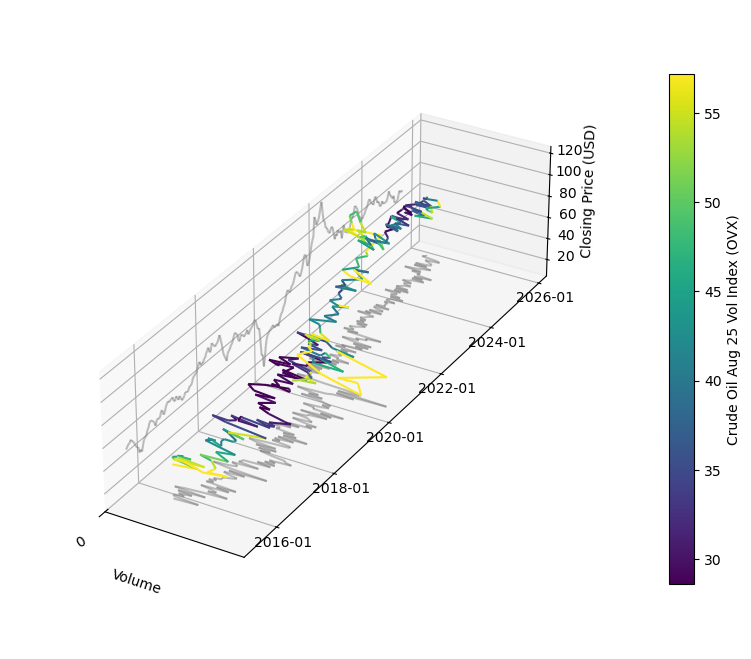

In [62]:
# 1) Sort and extract weekly series
asset_weekly = asset_weekly.sort_values('Date')
vols       = asset_weekly['Volume'].values
dates_w    = asset_weekly['Date']
prices     = asset_weekly['Closing Price (USD)'].values
date_nums_w = mdates.date2num(dates_w)

# 1b) Sort and extract VT series
asset_vol_time = asset_vol_time.sort_values('Date')
prices_VT    = asset_vol_time['Closing Price (USD)'].values

# 1c) Sort and extract PT series
asset_price_time = asset_price_time.sort_values('Date')
vols_PT        = asset_price_time['Volume'].values

# 2) Build segments for each
def make_segments(x, y, z):
    pts = np.stack([x, y, z], axis=1)         # (N,3)
    return np.stack([pts[:-1], pts[1:]], axis=1)  # (N-1,2,3)

segments    = make_segments(vols,    date_nums_w, prices)

vols_range = vols.max() - vols.min()
x_axis_d = vols_range/(2*vols.max()/vols.min())

vols_PT_offset = vols_PT + np.round(vols.min() - x_axis_d, -10)
segments_PT = make_segments(vols_PT_offset, date_nums_w, prices)

prices_VT_offset = prices_VT + prices.min()
segments_VT = make_segments(vols, date_nums_w, prices_VT_offset)

# 3) Plot setup
fig = plt.figure(figsize=(10, 15))
ax  = fig.add_subplot(111, projection='3d')

# optional scatter
ax.scatter(vols, date_nums_w, prices, color='gray', s=20, alpha=0, label='Weekly Points')

# 4) LineCollections
# norm     = Normalize(vmin=vol_low, vmax=vol_high, clip=True)
norm     = Normalize(*np.percentile(vix_I,[low_per,high_per]))
cmap     = plt.get_cmap('viridis')

lc = Line3DCollection(
    segments,
    cmap=cmap,
    norm=norm,
    linewidth=1.5
)

lc.set_array(vix_I[1:])
ax.add_collection(lc)

lc_VT = Line3DCollection(segments_VT, color='tab:gray', alpha=0.5, linewidth=1.5)
ax.add_collection(lc_VT)

lc_PT = Line3DCollection(segments_PT, color='tab:gray', alpha=0.5, linewidth=1.5)
ax.add_collection(lc_PT)

# 5) Format axis
plt.xticks(np.arange(np.round(vols.min() - x_axis_d, -10), vols.max(), 1e10))

ax.yaxis.set_major_locator(mdates.AutoDateLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# ax.zaxis.set_major_locator(mtick.MultipleLocator(1000))
ax.zaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}'))
ax.zaxis.set_minor_formatter(mtick.NullFormatter())

# 6) Labels, legend & colorbar
ax.set_xlabel('Volume')
# ax.set_ylabel('Date')
ax.set_zlabel('Closing Price (USD)')

# attach a colorbar to the line
cbar = fig.colorbar(lc, pad=0.025, ax=ax, shrink=0.5)
cbar.set_label(f'{asset_name} Vol Index ({vol_name})')

# 7) Adjust to cuboid aspect
ax.set_box_aspect((1, 4, 1))

# ax.view_init(azim=-90, elev=0)
plt.show()

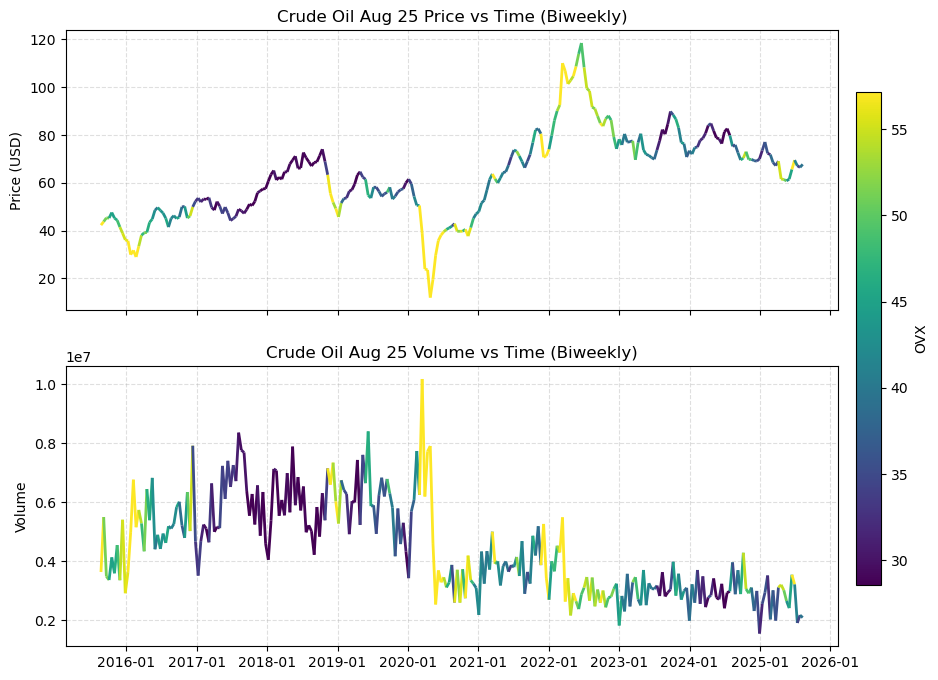

In [63]:
## 2D plots

# Helper to turn x,y into line segments for a LineCollection
def make_segments_2d(x, y):
    pts = np.stack([x, y], axis=1)             # shape (N,2)
    return np.stack([pts[:-1], pts[1:]], axis=1)  # shape (N-1,2,2)

# Create the figure with two vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 8),
    sharex=True,
    gridspec_kw={'hspace': 0.2}
)

# Plot Volume vs Time with gradient coloring
segs_vt = make_segments_2d(date_nums_w, vols)
lc_vt   = LineCollection(segs_vt, cmap=cmap, norm=norm, linewidth=2)
lc_vt.set_array(vix_I[1:])   # color each segment by the VIX at its end
ax2.add_collection(lc_vt)
ax2.set_ylabel('Volume')
ax2.set_title(f'{asset_name} Volume vs Time (Biweekly)')
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.autoscale()

# Plot Price vs Time with the same gradient
segs_pt = make_segments_2d(date_nums_w, prices)
lc_pt   = LineCollection(segs_pt, cmap=cmap, norm=norm, linewidth=2)
lc_pt.set_array(vix_I[1:])
ax1.add_collection(lc_pt)
ax1.set_ylabel('Price (USD)')
ax1.set_title(f'{asset_name} Price vs Time (Biweekly)')
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.autoscale()

# Format the shared X-axis as dates
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
for lbl in ax1.get_xticklabels():
    lbl.set_rotation(30)
    lbl.set_ha('right')

# Add one shared colorbar for both plots
cbar = fig.colorbar(lc_vt, ax=(ax1, ax2), pad=0.02, shrink=0.8)
cbar.set_label(f'{vol_name}')

# plt.tight_layout()
plt.show()

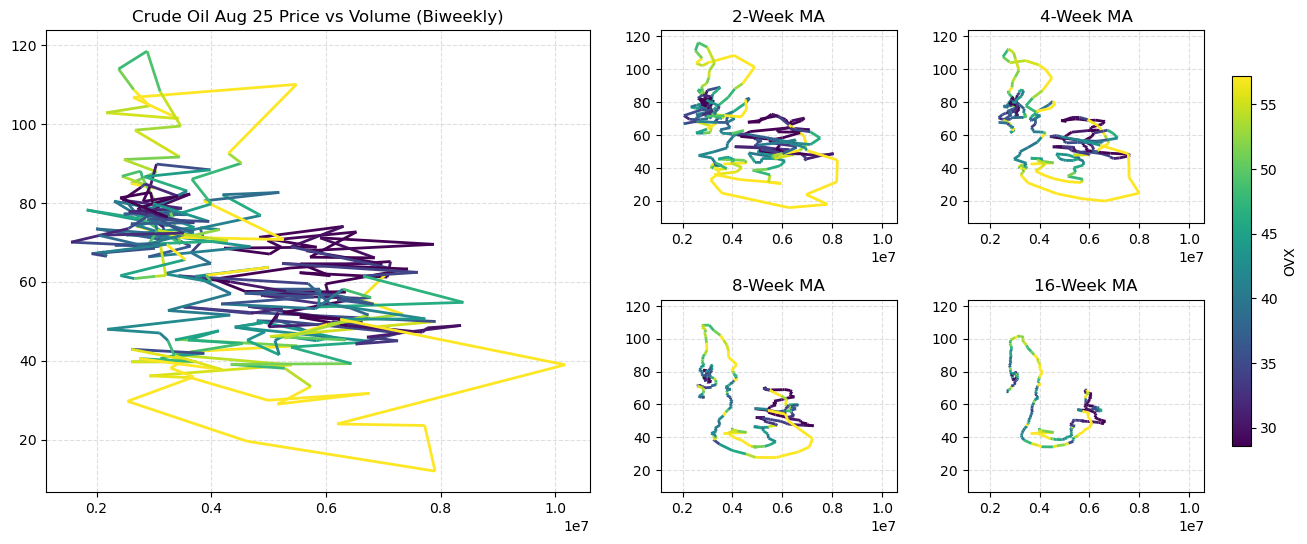

In [64]:
fig = plt.figure(figsize=(18, 6))
gs  = fig.add_gridspec(2, 4, wspace=0.3, hspace=0.4)



# big 2×2 axes
ax1 = fig.add_subplot(gs[:, :2])

# all the small axes now share both x and y with ax1
ax2 = fig.add_subplot(gs[0, 2], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[0, 3], sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(gs[1, 2], sharex=ax1, sharey=ax1)
ax5 = fig.add_subplot(gs[1, 3], sharex=ax1, sharey=ax1)

# --- now plot into ax1…ax5 exactly as before ---
segs_pv = make_segments_2d(vols, prices)
lc_pv   = LineCollection(segs_pv, cmap=cmap, norm=norm, linewidth=2)
lc_pv.set_array(vix_I[1:])
ax1.add_collection(lc_pv)
ax1.set_title(f'{asset_name} Price vs Volume (Biweekly)')
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.autoscale()

w_2W    = 2
w_4W    = 4
w_8W    = 8
w_16W   = 16

# 2 Week MA
prices_ma_2W = pd.Series(prices).rolling(w_2W, min_periods=1).mean()
vols_ma_2W   = pd.Series(vols).rolling(w_2W, min_periods=1).mean()
mask_ma_2W   = ~prices_ma_2W.isna()
x_ma_2W = vols_ma_2W[mask_ma_2W].to_numpy()
z_ma_2W = prices_ma_2W[mask_ma_2W].to_numpy()

segs_pv_2W = make_segments_2d(x_ma_2W, z_ma_2W)
lc_pv_2W   = LineCollection(segs_pv_2W, cmap=cmap, norm=norm, linewidth=2)
lc_pv_2W.set_array(vix_I[1:])
ax2.add_collection(lc_pv_2W)
ax2.set_title('2-Week MA')
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.autoscale()

# 4 Week MA
prices_ma_4W = pd.Series(prices).rolling(w_4W, min_periods=1).mean()
vols_ma_4W   = pd.Series(vols).rolling(w_4W, min_periods=1).mean()
mask_ma_4W   = ~prices_ma_4W.isna()
x_ma_4W = vols_ma_4W[mask_ma_4W].to_numpy()
z_ma_4W = prices_ma_4W[mask_ma_4W].to_numpy()

segs_pv_4W = make_segments_2d(x_ma_4W, z_ma_4W)
lc_pv_4W   = LineCollection(segs_pv_4W, cmap=cmap, norm=norm, linewidth=2)
lc_pv_4W.set_array(vix_I[1:])
ax3.add_collection(lc_pv_4W)
ax3.set_title('4-Week MA')
ax3.grid(True, linestyle='--', alpha=0.4)
ax3.autoscale()

# 8 Week MA
prices_ma_8W = pd.Series(prices).rolling(w_8W, min_periods=1).mean()
vols_ma_8W   = pd.Series(vols).rolling(w_8W, min_periods=1).mean()
mask_ma_8W   = ~prices_ma_8W.isna()
x_ma_8W = vols_ma_8W[mask_ma_8W].to_numpy()
z_ma_8W = prices_ma_8W[mask_ma_8W].to_numpy()

segs_pv_8W = make_segments_2d(x_ma_8W, z_ma_8W)
lc_pv_8W   = LineCollection(segs_pv_8W, cmap=cmap, norm=norm, linewidth=2)
lc_pv_8W.set_array(vix_I[1:])
ax4.add_collection(lc_pv_8W)
ax4.set_title('8-Week MA')
ax4.grid(True, linestyle='--', alpha=0.4)
ax4.autoscale()

# 16 Week MA
prices_ma_16W = pd.Series(prices).rolling(w_16W, min_periods=1).mean()
vols_ma_16W   = pd.Series(vols).rolling(w_16W, min_periods=1).mean()
mask_ma_16W   = ~prices_ma_16W.isna()
x_ma_16W = vols_ma_16W[mask_ma_16W].to_numpy()
z_ma_16W = prices_ma_16W[mask_ma_16W].to_numpy()

segs_pv_16W = make_segments_2d(x_ma_16W, z_ma_16W)
lc_pv_16W   = LineCollection(segs_pv_16W, cmap=cmap, norm=norm, linewidth=2)
lc_pv_16W.set_array(vix_I[1:])
ax5.add_collection(lc_pv_16W)
ax5.set_title('16-Week MA')
ax5.grid(True, linestyle='--', alpha=0.4)
ax5.autoscale()

# shared colorbar
cbar = fig.colorbar(lc_pv, ax=[ax1, ax2, ax3, ax4, ax5],
                    pad=0.02, shrink=0.8)
cbar.set_label(f'{vol_name}')
plt.show()


c:\Users\lucas\anaconda3\envs\py3.11.9\Lib\site-packages\scipy\interpolate\_fitpack_py.py:304: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)


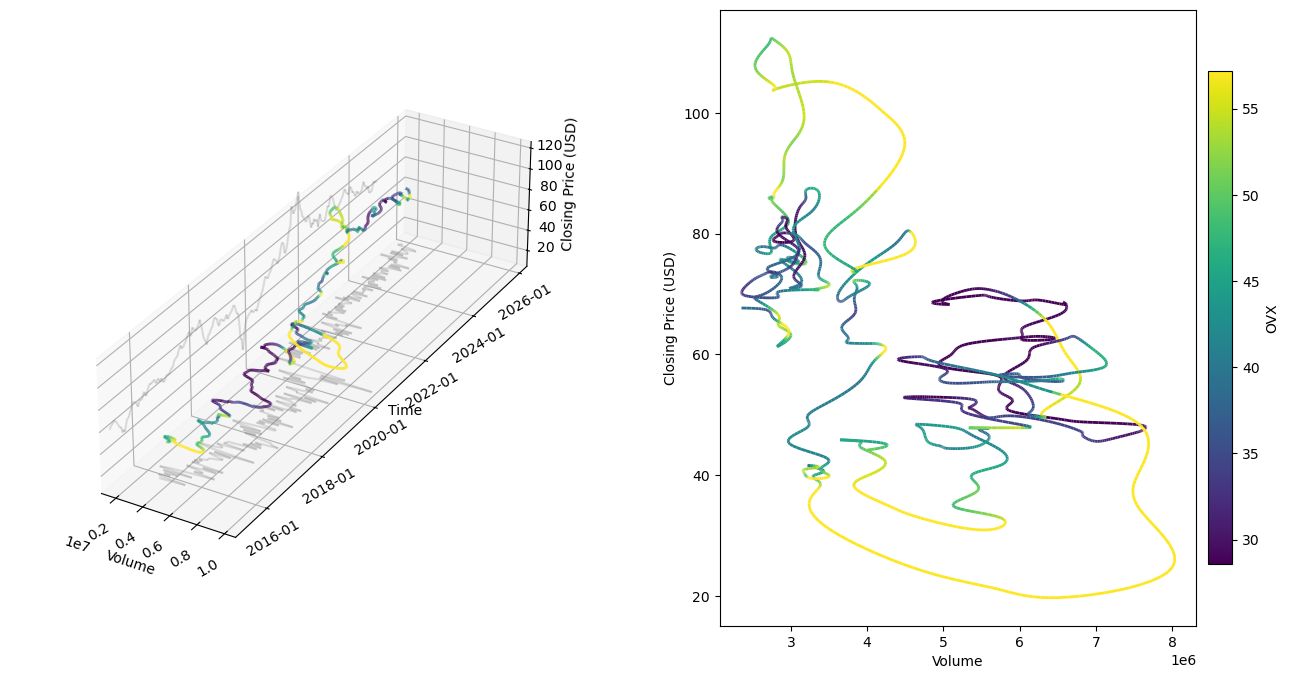

In [65]:
# --- 1) compute weekly moving average as before ---
window = 4
prices_ma = pd.Series(prices).rolling(window).mean()
vols_ma   = pd.Series(vols).rolling(window).mean()
mask_ma   = ~prices_ma.isna()

x_ma   = vols_ma[mask_ma].to_numpy()
y_ma   = date_nums_w[mask_ma]            # matplotlib date numbers
z_ma   = prices_ma[mask_ma].to_numpy()
vol_ma = vix_I[mask_ma.to_numpy()]

# --- 2) Parametric spline using a uniform parameter t ---
n = len(x_ma)
t = np.arange(n)
# Fine parameter for upsampling
t_fine = np.linspace(0, n-1, n*10)

# Fit separate splines with smoothing
smoothing = 1e-3 * n  # adjust scale relative to data length
tck_x = splrep(t, x_ma, s=smoothing)
tck_y = splrep(t, y_ma.astype(float), s=smoothing)
tck_z = splrep(t, z_ma, s=smoothing)

# Evaluate at fine parameter values
x_sp = splev(t_fine, tck_x)
y_sp = splev(t_fine, tck_y)
z_sp = splev(t_fine, tck_z)

# Interpolate VIX onto fine t
vix_sp = np.interp(t_fine, t, vol_ma)

# Build segments for plotting
segments_sp = make_segments(x_sp, y_sp, z_sp)

# Make a 1×2 grid with width ratio 3:2
fig = plt.figure(figsize=(20,8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 2], wspace=-0.2, figure=fig)

# --- Left: 3D plot (no colorbar here) ---
ax1 = fig.add_subplot(gs[0], projection='3d')

# hide any scatter by setting alpha=0
ax1.scatter(vols, date_nums_w, prices,
            color='gray', s=20, alpha=0)

# background VT & PT lines
ax1.add_collection(Line3DCollection(segments_VT,
    color='tab:gray', alpha=0.25, linewidth=1.5))
ax1.add_collection(Line3DCollection(segments_PT,
    color='tab:gray', alpha=0.25, linewidth=1.5))

# the smoothed spline line
lc3 = Line3DCollection(segments_sp, cmap=cmap, norm=norm,
                       linewidth=2.0, alpha=1)
lc3.set_array(vix_sp[1:])
ax1.add_collection(lc3)

# formatting
ax1.set_xlabel('Volume')
ax1.set_ylabel('Time')
ax1.set_zlabel('Closing Price (USD)')
ax1.yaxis.set_major_locator(mdates.AutoDateLocator())
ax1.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.zaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}'))
ax1.set_box_aspect((1,4,1))
plt.setp(ax1.get_xticklabels(), rotation=30)
plt.setp(ax1.get_yticklabels(), rotation=30)
# ax1.set_title(f'{asset_name}: 3D Volume vs Time vs Price ({window} Week MA Smoothened Line)')


# --- Right: 2D smooth line (no scatter points) ---
ax2 = fig.add_subplot(gs[1])

# build 2D segments from the upsampled spline coords
segs2d = [((x_sp[i], z_sp[i]), (x_sp[i+1], z_sp[i+1])) 
          for i in range(len(x_sp)-1)]
lc2 = LineCollection(segs2d, cmap=cmap, norm=norm,
                     linewidth=2.0, alpha=1.0)
lc2.set_array(vix_sp[1:])
ax2.add_collection(lc2)

ax2.autoscale()

ax2.set_xlabel('Volume')
ax2.set_ylabel('Closing Price (USD)')
# ax2.set_title(f'{asset_name}: 2D Price vs Volume ({window} Week MA Smoothened Line)')


# --- Single colorbar on the right ---
cbar = fig.colorbar(lc2, ax=ax2, pad=0.02, shrink=0.8)
cbar.set_label(f'{vol_name}')

# plt.tight_layout()
plt.show()

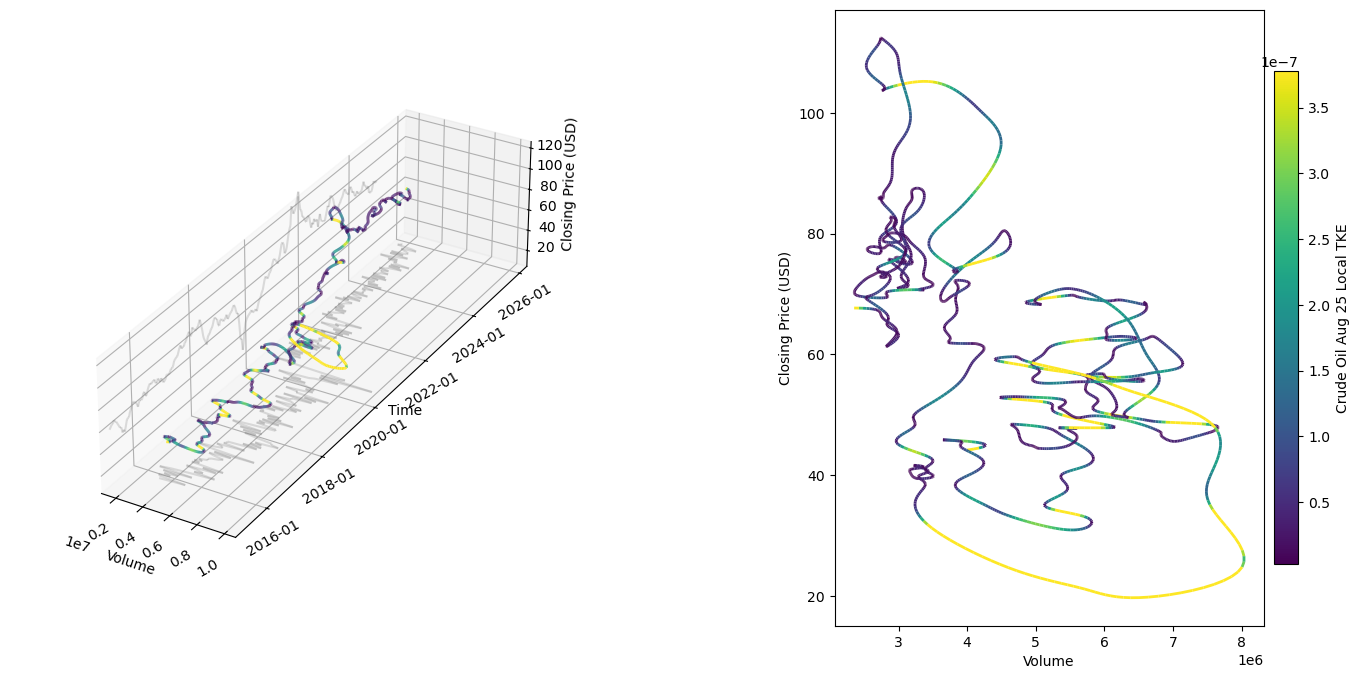

In [66]:
# --- NEW: 2a) normalize both axes to [0,1] before derivatives ---
#   this makes "units" of Δvolume and Δprice directly comparable
x_sp_n = (x_sp - x_sp.min()) / (x_sp.max() - x_sp.min())
z_sp_n = (z_sp - z_sp.min()) / (z_sp.max() - z_sp.min())

# --- 3) compute the TKE analogue on the NORMALISED axes ---
dt   = 14.0                     # two-week step in days
dzdt = np.diff(z_sp_n) / dt     # price-rate on normalized price
dxdt = np.diff(x_sp_n) / dt     # volume-rate on normalized volume

TKE  = 0.5*(dzdt**2 + dxdt**2)  # length = len(x_sp)-1

# --- 4) build spline segments for plotting with the original coords ---
segments_sp = make_segments(x_sp, y_sp, z_sp)

# --- 5) two-panel figure, colored by TKE ---
fig = plt.figure(figsize=(20,8))
gs  = gridspec.GridSpec(1,2, width_ratios=[4,2], wspace=0.0, figure=fig)

# prepare a clipped norm (5th–95th percentile)
vmin, vmax = np.percentile(TKE, [5,95])
norm_tke   = Normalize(vmin=vmin, vmax=vmax, clip=True)
cmap       = plt.get_cmap('viridis')

# --- Left: 3D Volume–Time–Price ---
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.scatter(vols, date_nums_w, prices, alpha=0)

ax1.add_collection(Line3DCollection(
    segments_VT, color='tab:gray', alpha=0.25, linewidth=1.5))
ax1.add_collection(Line3DCollection(
    segments_PT, color='tab:gray', alpha=0.25, linewidth=1.5))

lc3 = Line3DCollection(
    segments_sp, cmap=cmap, norm=norm_tke,
    linewidth=2.0, alpha=1.0
)
lc3.set_array(TKE)
ax1.add_collection(lc3)

ax1.set_xlabel('Volume')
ax1.set_ylabel('Time')
ax1.set_zlabel('Closing Price (USD)')
ax1.yaxis.set_major_locator(mdates.AutoDateLocator())
ax1.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.zaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}'))
ax1.set_box_aspect((1,4,1))
plt.setp(ax1.get_xticklabels(), rotation=30)
plt.setp(ax1.get_yticklabels(), rotation=30)

# --- Right: 2D Price vs Volume spline ---
ax2 = fig.add_subplot(gs[1])
segs2d = [((x_sp[i], z_sp[i]), (x_sp[i+1], z_sp[i+1]))
          for i in range(len(x_sp)-1)]

lc2 = LineCollection(
    segs2d, cmap=cmap, norm=norm_tke,
    linewidth=2.0, alpha=1.0
)
lc2.set_array(TKE)
ax2.add_collection(lc2)
ax2.autoscale()

ax2.set_xlabel('Volume')
ax2.set_ylabel('Closing Price (USD)')

# single colorbar on the right
cbar = fig.colorbar(lc2, ax=ax2, pad=0.02, shrink=0.8)
cbar.set_label(f'{asset_name} Local TKE')

plt.show()


C:\Users\lucas\AppData\Local\Temp\ipykernel_31700\3329357916.py:74: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


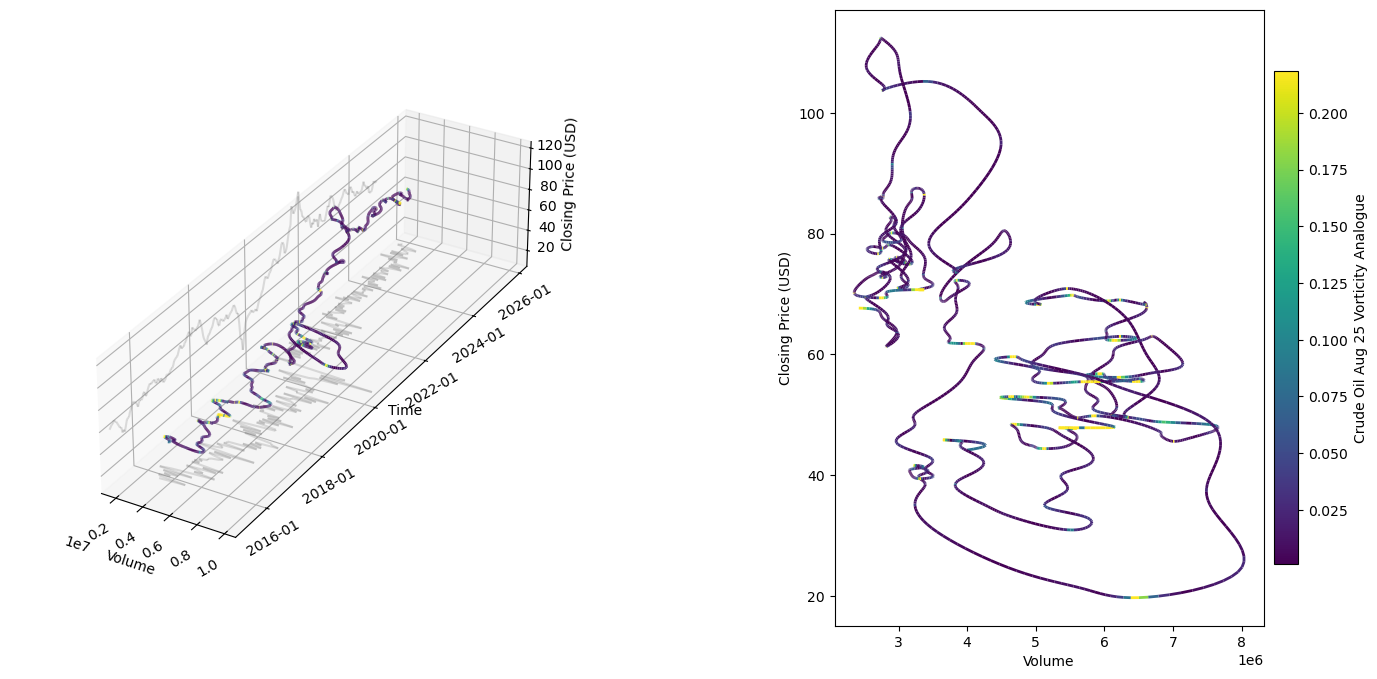

In [67]:
# 4) Build full spline segments for plotting
def make_segments(x, y, z):
    pts = np.stack([x, y, z], axis=1)
    return np.stack([pts[:-1], pts[1:]], axis=1)

segments_sp = make_segments(x_sp, y_sp, z_sp)

# 5) Compute vorticity analogue using the SAME fixed Δt as TKE (bi-weekly)
dt_bi = 14.0  # days

# first-order derivatives (length M-1)
u = np.diff(x_sp_n) / dt_bi         # ∂(norm-vol)/∂t (bi-weekly)
w = np.diff(z_sp_n) / dt_bi         # ∂(norm-price)/∂t (bi-weekly)

# second-order differences (length M-2)
du = np.diff(u)
dw = np.diff(w)

# spatial increments (length M-2)
dx = x_sp_n[2:] - x_sp_n[:-2]
dz = z_sp_n[2:] - z_sp_n[:-2]

omega = np.abs(du/dz - dw/dx)       # vorticity analogue (bi-weekly time base)

# (optional but robust) guard against tiny denominators:
epsx = 1e-4*np.median(np.abs(dx)) if np.median(np.abs(dx))>0 else 1e-12
epsz = 1e-4*np.median(np.abs(dz)) if np.median(np.abs(dz))>0 else 1e-12
valid = (np.abs(dx)>epsx) & (np.abs(dz)>epsz)
omega = omega[valid]

# trim segments to match ω
segments_mid = segments_sp[1:-1]    # also length M-2
# segments_mid = segments_mid[valid] # <- if using the optional mask

# 6) Two-panel plot colored by ω
fig = plt.figure(figsize=(20,8))
gs  = gridspec.GridSpec(1,2, width_ratios=[4,2], wspace=0.0, figure=fig)

vmin, vmax = np.percentile(omega, [5,95])
norm_ω     = Normalize(vmin=vmin, vmax=vmax, clip=True)
cmap       = plt.get_cmap('viridis')

# — Left: 3D Volume–Time–Price —
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.scatter(vols, date_nums_w, prices, alpha=0)  # hide raw points
ax1.add_collection(Line3DCollection(segments_VT, color='tab:gray', alpha=0.25, linewidth=1.5))
ax1.add_collection(Line3DCollection(segments_PT, color='tab:gray', alpha=0.25, linewidth=1.5))

lc3 = Line3DCollection(segments_mid, cmap=cmap, norm=norm_ω, linewidth=2.0, alpha=1.0)
lc3.set_array(omega)
ax1.add_collection(lc3)

ax1.set_xlabel('Volume'); ax1.set_ylabel('Time'); ax1.set_zlabel('Closing Price (USD)')
ax1.yaxis.set_major_locator(mdates.AutoDateLocator())
ax1.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.zaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}'))
ax1.set_box_aspect((1,4,1))
plt.setp(ax1.get_xticklabels(), rotation=30); plt.setp(ax1.get_yticklabels(), rotation=30)

# — Right: 2D Price vs Volume —
ax2 = fig.add_subplot(gs[1])
segs2d = [((x_sp[i], z_sp[i]), (x_sp[i+1], z_sp[i+1])) for i in range(len(omega))]
# If masking: use indices of 'valid' to build segs2d consistently

lc2 = LineCollection(segs2d, cmap=cmap, norm=norm_ω, linewidth=2.0, alpha=1.0)
lc2.set_array(omega)
ax2.add_collection(lc2)
ax2.autoscale()
ax2.set_xlabel('Volume'); ax2.set_ylabel('Closing Price (USD)')

cbar = fig.colorbar(lc2, ax=ax2, pad=0.02, shrink=0.8)
cbar.set_label(f"{asset_name} Vorticity Analogue")

plt.tight_layout()
plt.show()

## Reynolds Number Financial Analogue

In [68]:
start_date = "2015-06-18"
end_date = "2025-06-18"
interval = "1d"

## Chose asset

# #  S&P500  #  
# asset = "^GSPC"
# asset_name = "S&P 500"

#  E-Mini S&P 500 Sep 25  #  
asset = "ES=F"
asset_name = "E-Mini S&P 500 Sep 25"

# #  Crude Oil  #  
# asset = "CL=F"
# asset_name = "Crude Oil Aug 25"

# #  Gold  #  
# asset = "GLD"
# asset_name = "Gold"

####################################################################################

asset_Re = yf.download(asset, 
                    start=start_date, 
                    end=end_date,
                    interval=interval)

# Change column labels
asset_Re = asset_Re.reset_index()
labels_Re = ['Date', 'Closing Price (USD)', 'High', 'Low', 'Open', 'Volume']
asset_Re.columns = labels_Re
asset_Re.drop(columns=["High", "Low", "Open", "Date", "Volume"], inplace=True)

# Clean columns
asset_Re = asset_Re.dropna()
asset_Re = asset_Re[asset_Re > 0]
asset_Re = asset_Re.reset_index(drop=True)
asset_Re = np.array(asset_Re)  # ensure it’s an array

# 1. Compute log‐returns
returns = np.log(asset_Re[1:] / asset_Re[:-1])
N = len(returns)

# 2. Mean return
phi = np.mean(np.abs(returns))                 
sigma_RV = np.sqrt(np.sum(returns**2))         

# 3. Lag‐1 autocovariance
r_bar = returns.mean()
cov_lag1 = np.sum((returns[1:] - r_bar) * (returns[:-1] - r_bar)) / (N - 1)
print(f"{asset_name} Covariance = {cov_lag1}")

# 4. Roll’s implied spread (guard negative)
if cov_lag1 < 0:
    hat_s = 2 * np.sqrt(-cov_lag1)
else:
    hat_s = 0.0

# 5. Financial Reynolds numbers (avoid divide‐by‐zero)
Re_phi   = phi   / hat_s if hat_s > 0 else np.nan
Re_sigma = sigma_RV / hat_s if hat_s > 0 else np.nan

# 6. Package results
results = pd.DataFrame({
    'Metric': ['phi (mean abs return)',
               'sigma_RV (realised volatility)',
               'hat_s (implied spread)',
               'Re_phi',
               'Re_sigma'],
    'Value': [phi, sigma_RV, hat_s, Re_phi, Re_sigma]
})

results

C:\Users\lucas\AppData\Local\Temp\ipykernel_31700\2756114900.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_Re = yf.download(asset,
[*********************100%***********************]  1 of 1 completed

E-Mini S&P 500 Sep 25 Covariance = -1.729752077280192e-05


,Metric,Value
0,phi (mean abs return),0.007499
1,sigma_RV (realised volatility),0.584871
2,hat_s (implied spread),0.008318
3,Re_phi,0.901514
4,Re_sigma,70.313447


In [69]:
def compute_financial_reynolds(assets, start_date, end_date, interval):
    """
    assets     : list of (ticker, name) tuples
    start_date : str “YYYY-MM-DD”
    end_date   : str “YYYY-MM-DD”
    interval   : str, e.g. “1d”, “5m”
    """
    results = []

    for ticker, name in assets:
        df = yf.download(
            ticker,
            start=start_date,
            end=end_date,
            interval=interval,
            auto_adjust=True,
            progress=False
        )
        if df.empty:
            continue

        prices = df["Close"].dropna()
        prices = prices[prices > 0].reset_index(drop=True).values
        if len(prices) < 2:
            continue

        # log‐returns
        returns = np.log(prices[1:] / prices[:-1])
        N = len(returns)

        # inertial metrics
        phi      = np.mean(np.abs(returns))
        sigma_RV = np.sqrt(np.mean(np.sum(returns**2)))

        # lag‐1 autocovariance
        r_bar   = returns.mean()
        cov_lag1 = np.sum((returns[1:] - r_bar) * (returns[:-1] - r_bar)) / (N - 1)

        # implied spread (Roll)
        hat_s = 2 * np.sqrt(-cov_lag1) if cov_lag1 < 0 else np.nan

        # # improved spread
        hat_s = 2 * np.sqrt(np.abs(cov_lag1))
        hat_s = np.sqrt(hat_s)

        # Reynolds numbers
        Re_phi   = phi      / hat_s if hat_s > 0 else np.nan
        Re_sigma = sigma_RV / hat_s if hat_s > 0 else np.nan

        results.append({
            "Ticker":   ticker,
            "Name":     name,
            "phi":      phi,
            "sigma_RV": sigma_RV,
            "hat_s":    hat_s,
            "Re_phi":   Re_phi,
            "Re_sigma": Re_sigma
        })

    return pd.DataFrame(results)


# Example usage:
assets = [
    # Commodities
    ("CL=F",    "Crude Oil WTI"),
    ("BZ=F",    "Brent Crude Oil"),
    ("NG=F",    "Natural Gas"),
    ("HO=F",    "Heating Oil"),
    ("RB=F",    "RBOB Gasoline"),
    ("GC=F",    "Gold"),
    ("SI=F",    "Silver"),
    ("HG=F",    "Copper"),
    ("PL=F",    "Platinum"),
    ("PA=F",    "Palladium"),
    ("CT=F",    "Cotton"),
    ("CC=F",    "Cocoa"),
    ("KC=F",    "Coffee"),
    ("SB=F",    "Sugar"),
    ("ZW=F",    "Wheat"),
    ("ZC=F",    "Corn"),

    # Indices
    ("ES=F",    "E-Mini S&P 500"),
    ("YM=F",    "E-Mini Dow Jones"),
    ("NQ=F",    "E-Mini NASDAQ 100"),
    ("RTY=F",   "E-Mini Russell 2000"),
    ("^GSPC",   "S&P 500 Index"),
    ("^DJI",    "Dow Jones Industrial Average"),
    ("^IXIC",   "NASDAQ Composite"),
    ("^FTSE",   "FTSE 100"),
    ("^GDAXI",  "DAX Performance Index"),
    ("^N225",   "Nikkei 225"),
    ("^HSI",    "Hang Seng Index"),

    # Currencies
    ("EURUSD=X","EUR/USD"),
    ("USDJPY=X","USD/JPY"),
    ("GBPUSD=X","GBP/USD"),
    ("AUDUSD=X","AUD/USD"),
    ("NZDUSD=X","NZD/USD"),
    ("USDCAD=X","USD/CAD"),
    ("EURGBP=X","EUR/GBP"),
    ("EURCHF=X","EUR/CHF"),
    ("USDCHF=X","USD/CHF"),
    ("USDBRL=X","USD/BRL"),
    ("USDMXN=X","USD/MXN"),
    ("USDZAR=X","USD/ZAR"),
    ("USDINR=X","USD/INR"),
    ("USDSGD=X","USD/SGD"),

    # Bonds & Rates
    ("ZB=F",    "30Y U.S. Treasury Bond"),
    ("ZN=F",    "10Y U.S. Treasury Note"),
    ("ZF=F",    "5Y U.S. Treasury Note"),
    ("ZT=F",    "2Y U.S. Treasury Note"),
    # ("^TNX",    "CBOE 10Y Treasury Yield"),
    # ("^FVX",    "CBOE 5Y Treasury Yield"),
    # ("^IRX",    "CBOE 13W Treasury Bill Rate"),

    # Large-cap Stocks
    # ("AAPL",    "Apple Inc."),
    # ("MSFT",    "Microsoft Corporation"),
    # ("AMZN",    "Amazon.com Inc."),
    # ("GOOGL",   "Alphabet Inc."),
    # ("META",    "Meta Platforms, Inc."),
    # ("TSLA",    "Tesla, Inc."),
    # ("NVDA",    "NVIDIA Corporation"),
    # ("XOM",     "Exxon Mobil Corporation"),
    # ("CVX",     "Chevron Corporation"),
    # ("JPM",     "JPMorgan Chase & Co."),
    # ("GS",      "Goldman Sachs Group, Inc."),
    # ("PFE",     "Pfizer Inc."),
    # ("MRK",     "Merck & Co., Inc."),
]
start_date = "2025-01-18"
end_date   = "2025-07-18"
interval   = "1d"

df_results = compute_financial_reynolds(assets, start_date, end_date, interval)
df_results = df_results.sort_values('Re_phi', ascending=False).reset_index(drop=True)
df_results


1 Failed download:
['BZ=F']: Timeout('Failed to perform, curl: (28) Connection timed out after 10016 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')

1 Failed download:
['NG=F']: Timeout('Failed to perform, curl: (28) Connection timed out after 10012 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


,Ticker,Name,phi,sigma_RV,hat_s,Re_phi,Re_sigma
0,GBPUSD=X,GBP/USD,0.004007,0.058056,0.010060,0.398299,5.771181
1,SB=F,Sugar,0.013487,0.188426,0.042992,0.313697,4.382778
2,CC=F,Cocoa,0.029832,0.442848,0.112562,0.265031,3.934257
3,KC=F,Coffee,0.018118,0.265225,0.075178,0.241004,3.527984
4,PL=F,Platinum,0.016005,0.230075,0.078597,0.203634,2.927260
5,HO=F,Heating Oil,0.015881,0.227850,0.082145,0.193335,2.773755
6,RB=F,RBOB Gasoline,0.013934,0.224058,0.073925,0.188493,3.030890
7,CL=F,Crude Oil WTI,0.016403,0.253659,0.090758,0.180732,2.794900
8,NZDUSD=X,NZD/USD,0.005455,0.085671,0.031829,0.171401,2.691632
9,EURUSD=X,EUR/USD,0.004406,0.067256,0.028720,0.153396,2.341790


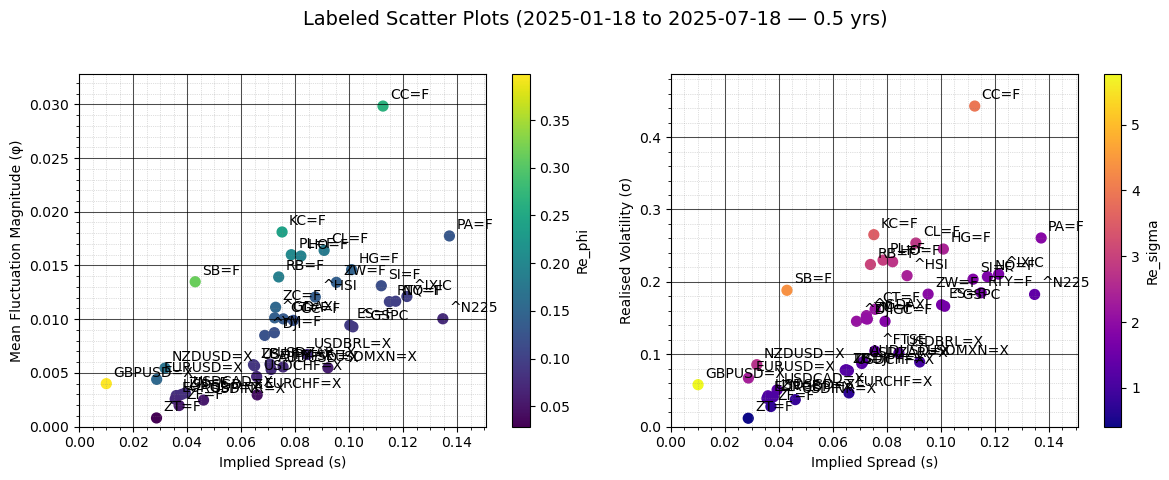

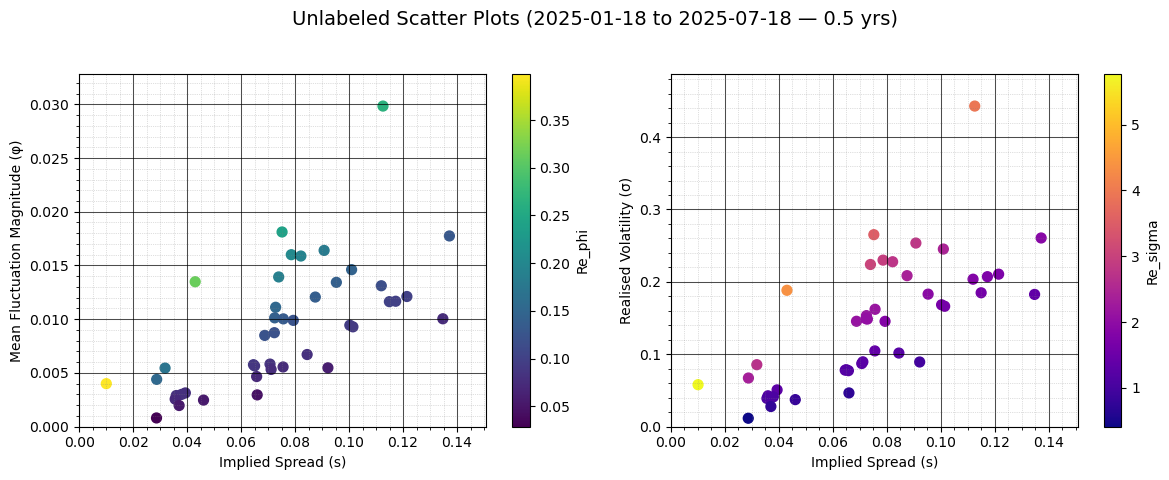

In [70]:
# Filter for non-zero spread
df_plot = df_results[df_results['hat_s'] > 0]

# Date span for titles
sd = datetime.datetime.strptime(start_date, "%Y-%m-%d")
ed = datetime.datetime.strptime(end_date,   "%Y-%m-%d")
span_years = (ed - sd).days / 365.0
xmax = df_plot['hat_s'].max() * 1.1
ymax_phi = df_plot['phi'].max() * 1.1
ymax_sigma = df_plot['sigma_RV'].max() * 1.1

# Figure 1: with point labels
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
for ax, (ycol, ylabel, cmap, label) in zip(
    (ax1, ax2),
    [('phi', 'Mean Fluctuation Magnitude (φ)', 'viridis', 'Re_phi'),
     ('sigma_RV', 'Realised Volatility (σ)', 'plasma', 'Re_sigma')]):
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(which='major', linestyle='-', linewidth=0.75, color='black', alpha=0.7)
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax_phi if ycol == 'phi' else ymax_sigma)
    sc = ax.scatter(df_plot['hat_s'], df_plot[ycol], c=df_plot[label], cmap=cmap, s=50)
    for _, row in df_plot.iterrows():
        ax.annotate(row['Ticker'], (row['hat_s'], row[ycol]),
                    textcoords="offset points", xytext=(5,5), ha='left')
    ax.set_xlabel('Implied Spread (s)')
    ax.set_ylabel(ylabel)
    # ax.set_title(('Inertia vs Liquidity' if ycol=='phi' else 'Volatility vs Liquidity'))
    fig1.colorbar(sc, ax=ax, label=label)
fig1.suptitle(f'Labeled Scatter Plots ({start_date} to {end_date} — {span_years:.1f} yrs)', fontsize=14)
fig1.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

# Figure 2: without point labels
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))
for ax, (ycol, ylabel, cmap, label) in zip(
    (ax3, ax4),
    [('phi', 'Mean Fluctuation Magnitude (φ)', 'viridis', 'Re_phi'),
     ('sigma_RV', 'Realised Volatility (σ)', 'plasma', 'Re_sigma')]):
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(which='major', linestyle='-', linewidth=0.75, color='black', alpha=0.7)
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax_phi if ycol=='phi' else ymax_sigma)
    sc = ax.scatter(df_plot['hat_s'], df_plot[ycol], c=df_plot[label], cmap=cmap, s=50)
    ax.set_xlabel('Implied Spread (s)')
    ax.set_ylabel(ylabel)
    # ax.set_title(('Inertia vs Liquidity' if ycol=='phi' else 'Volatility vs Liquidity'))
    fig2.colorbar(sc, ax=ax, label=label)
fig2.suptitle(f'Unlabeled Scatter Plots ({start_date} to {end_date} — {span_years:.1f} yrs)', fontsize=14)
fig2.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

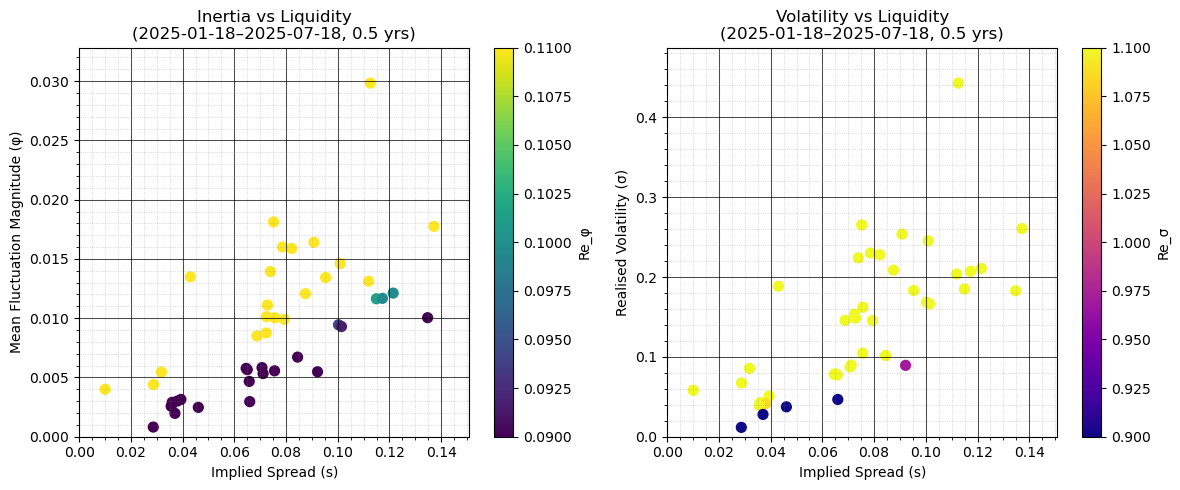

In [71]:
# Filter out zero‐spread entries
df_plot = df_results[df_results['hat_s'] > 0]

# Parse dates for title
sd = datetime.datetime.strptime(start_date, "%Y-%m-%d")
ed = datetime.datetime.strptime(end_date,   "%Y-%m-%d")
span_years = (ed - sd).days / 365.0

# Compute axis limits with padding
xmax = df_plot['hat_s'].max() * 1.1
ymax_phi   = df_plot['phi'].max() * 1.1
ymax_sigma = df_plot['sigma_RV'].max() * 1.1

# Compute ±1 std dev thresholds for color scaling
# mean_phi = df_plot['Re_phi'].mean()
# std_phi = df_plot['Re_phi'].std()
# vmin_phi = 0.9
# vmax_phi = 1.1

# mean_sigma = df_plot['Re_sigma'].mean()
# std_sigma = df_plot['Re_sigma'].std()
# constant = 10
# vmin_sigma = constant*vmin_phi
# vmax_sigma = constant*vmax_phi

vmin_phi = 0.09
vmax_phi = 0.11

constant = 10
vmin_sigma = constant*vmin_phi
vmax_sigma = constant*vmax_phi

# Create side‐by‐side scatter plots without labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Common grid and axis settings
for ax, ycol, ymax in zip(
    (ax1, ax2),
    ('phi', 'sigma_RV'),
    (ymax_phi, ymax_sigma)
):
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(which='major', linestyle='-', linewidth=0.75, color='black', alpha=0.7)
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='gray', alpha=0.5)
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)

# Scatter φ vs hat_s with manual numeric color scaling
norm_phi = Normalize(vmin=vmin_phi, vmax=vmax_phi)
sc1 = ax1.scatter(
    df_plot['hat_s'], df_plot['phi'],
    c=df_plot['Re_phi'], cmap='viridis', norm=norm_phi, s=50
)
ax1.set_xlabel('Implied Spread (s)')
ax1.set_ylabel('Mean Fluctuation Magnitude (φ)')
ax1.set_title(f'Inertia vs Liquidity\n({start_date}–{end_date}, {span_years:.1f} yrs)')
cbar1 = fig.colorbar(sc1, ax=ax1, label='Re_φ')
# No custom tick labels; default numeric ticks shown

# Scatter σ_RV vs hat_s with manual numeric color scaling
norm_sigma = Normalize(vmin=vmin_sigma, vmax=vmax_sigma)
sc2 = ax2.scatter(
    df_plot['hat_s'], df_plot['sigma_RV'],
    c=df_plot['Re_sigma'], cmap='plasma', norm=norm_sigma, s=50
)
ax2.set_xlabel('Implied Spread (s)')
ax2.set_ylabel('Realised Volatility (σ)')
ax2.set_title(f'Volatility vs Liquidity\n({start_date}–{end_date}, {span_years:.1f} yrs)')
cbar2 = fig.colorbar(sc2, ax=ax2, label='Re_σ')
# No custom tick labels; default numeric ticks shown

plt.tight_layout()
plt.show()

In [72]:
phi_rank = df_results[['Name', 'phi']].sort_values('phi', ascending=False).reset_index(drop=True)
sigma_rank = df_results[['Name', 'sigma_RV']].sort_values('sigma_RV', ascending=False).reset_index(drop=True)
spread_rank = df_results[['Name', 'hat_s']].sort_values('hat_s', ascending=False).reset_index(drop=True)

# 1. Rank and label phi
Re_phi_rank = df_results[['Name', 'Re_phi']].sort_values('Re_phi', ascending=False).reset_index(drop=True)
Re_phi_rank['Regime'] = pd.cut(
    Re_phi_rank['Re_phi'],
    bins=[-np.inf, vmin_phi, vmax_phi, np.inf],
    labels=['laminar', 'transitional', 'turbulent']
)

# 2. Rank and label sigma_RV
Re_sigma_rank = df_results[['Name', 'Re_sigma']].sort_values('Re_sigma', ascending=False).reset_index(drop=True)
Re_sigma_rank['Regime'] = pd.cut(
    Re_sigma_rank['Re_sigma'],
    bins=[-np.inf, vmin_sigma, vmax_sigma, np.inf],
    labels=['laminar', 'transitional', 'turbulent']
)

Re_phi_rank

,Name,Re_phi,Regime
0,GBP/USD,0.398299,turbulent
1,Sugar,0.313697,turbulent
2,Cocoa,0.265031,turbulent
3,Coffee,0.241004,turbulent
4,Platinum,0.203634,turbulent
5,Heating Oil,0.193335,turbulent
6,RBOB Gasoline,0.188493,turbulent
7,Crude Oil WTI,0.180732,turbulent
8,NZD/USD,0.171401,turbulent
9,EUR/USD,0.153396,turbulent


In [73]:
Re_sigma_rank

,Name,Re_sigma,Regime
0,GBP/USD,5.771181,turbulent
1,Sugar,4.382778,turbulent
2,Cocoa,3.934257,turbulent
3,Coffee,3.527984,turbulent
4,RBOB Gasoline,3.030890,turbulent
5,Platinum,2.927260,turbulent
6,Crude Oil WTI,2.794900,turbulent
7,Heating Oil,2.773755,turbulent
8,NZD/USD,2.691632,turbulent
9,Copper,2.431004,turbulent


In [74]:
spread_rank

,Name,hat_s
0,Palladium,0.137174
1,Nikkei 225,0.134742
2,NASDAQ Composite,0.121420
3,E-Mini NASDAQ 100,0.117268
4,E-Mini Russell 2000,0.114940
5,Cocoa,0.112562
6,Silver,0.111937
7,S&P 500 Index,0.101423
8,Copper,0.100939
9,E-Mini S&P 500,0.100280


In [75]:
phi_rank

,Name,phi
0,Cocoa,0.029832
1,Coffee,0.018118
2,Palladium,0.017748
3,Crude Oil WTI,0.016403
4,Platinum,0.016005
5,Heating Oil,0.015881
6,Copper,0.014613
7,RBOB Gasoline,0.013934
8,Sugar,0.013487
9,Wheat,0.013432


In [76]:
sigma_rank

,Name,sigma_RV
0,Cocoa,0.442848
1,Coffee,0.265225
2,Palladium,0.260672
3,Crude Oil WTI,0.253659
4,Copper,0.245383
5,Platinum,0.230075
6,Heating Oil,0.227850
7,RBOB Gasoline,0.224058
8,NASDAQ Composite,0.210687
9,Hang Seng Index,0.208606


### EFC Spread


In [77]:
def estimate_hasbrouck_spread(returns, n_iter=1000, burn_in=200, V0=1e6, a0=2.0, b0=1e-6):
    """
    Bayesian Gibbs sampler for Hasbrouck (2004) spread estimator.
    returns: array of price returns Δp_t
    V0: prior variance for s ~ N(0, V0) truncated at 0
    a0, b0: priors for σ_u^2 ~ Inv-Gamma(a0, b0)
    """
    T = len(returns)
    # Initialize
    B = np.sign(returns)
    B[B == 0] = 1
    s = np.std(returns)  # init spread
    sigma2 = np.var(returns) / 2  # init variance of u
    
    s_samples = []
    
    for it in range(n_iter):
        # Sample B_t
        # Δp_t ~ N((s/2)*B_t, 2*sigma2)
        for t in range(T):
            # Prob of B_t = +1
            mu_plus = (s / 2)
            mu_minus = -(s / 2)
            like_plus = np.exp(-0.5 * (returns[t] - mu_plus)**2 / (2 * sigma2))
            like_minus = np.exp(-0.5 * (returns[t] - mu_minus)**2 / (2 * sigma2))
            p_plus = like_plus / (like_plus + like_minus)
            B[t] = 1 if np.random.rand() < p_plus else -1
        
        # Sample s | B, σ²
        # Posterior Precision: τ = T/(4 σ²) + 1/V0
        tau = T / (4 * sigma2) + 1 / V0
        # Posterior mean: m = (Σ B_t Δp_t)/(4 σ²) / τ
        m = (np.sum(B * returns) / (4 * sigma2)) / tau
        # Draw from truncated normal N(m, 1/τ), truncated at 0
        a, b = (0 - m) * np.sqrt(tau), np.inf
        s = truncnorm.rvs(a, b, loc=m, scale=np.sqrt(1 / tau))
        
        # Sample σ² | s, B
        # Residuals: Δp_t - (s/2)*B_t = ε_t - ε_{t-1}, approximate var=2σ²
        resid = returns - (s / 2) * B
        ssq = np.sum(resid**2) / 2
        alpha = a0 + T / 2
        beta = b0 + ssq
        sigma2 = invgamma.rvs(alpha, scale=beta)
        
        if it >= burn_in:
            s_samples.append(s)
    
    return np.mean(s_samples)

def compute_financial_reynolds(assets, start_date, end_date, interval, 
                               u_values=None, epsilon=1e-6):
    if u_values is None:
        u_values = [0.5, 1.0, 1.5, 2.0]
    
    results = []

    for ticker, name in assets:
        df = yf.download(ticker, start=start_date, end=end_date,
                         interval=interval, auto_adjust=True, progress=False)
        if df.empty:
            continue

        prices = df["Close"].dropna().values
        if len(prices) < 2:
            continue

        returns = np.log(prices[1:] / prices[:-1])
        N = len(returns)

        # inertial metrics
        phi = np.mean(np.abs(returns))
        sigma_RV = np.sqrt(np.sum(returns**2) / N)

        # lag-1 covariance
        r_bar = returns.mean()
        cov_lag1 = np.sum((returns[1:] - r_bar)*(returns[:-1] - r_bar)) / (N - 1)

        # 1. Roll's estimator
        roll_s = 2 * np.sqrt(np.abs(cov_lag1))

        # 2. Hasbrouck's Bayesian Gibbs sampler
        try:
            hasbrouck_s = estimate_hasbrouck_spread(returns)
        except Exception:
            hasbrouck_s = np.nan

        # 3. Chen et al. ECF estimator
        s_estimates = []
        for u in u_values:
            phi1 = np.mean(np.exp(1j * u * returns))
            phi2 = np.mean(np.exp(1j * (u * returns[1:] + u * returns[:-1])))
            H_hat = phi2 / (phi1 * phi1)
            arg = np.abs(H_hat)**(1/3)
            if arg < 1 - epsilon:
                s_u = (2 / u) * np.arccos(np.clip(arg, 0, 1 - epsilon))
                s_estimates.append(np.real(s_u))
        ecf_s = np.nanmean(s_estimates) if s_estimates else np.nan

        # # Reynolds ratios
        # Re_phi_roll = phi / roll_s if roll_s > 0 else np.nan
        # Re_phi_hasb = phi / hasbrouck_s if hasbrouck_s > 0 else np.nan
        # Re_phi_ecf  = phi / ecf_s if ecf_s > 0 else np.nan

        # Re_sigma_roll = sigma_RV / roll_s if roll_s > 0 else np.nan
        # Re_sigma_hasb = sigma_RV / hasbrouck_s if hasbrouck_s > 0 else np.nan
        # Re_sigma_ecf  = sigma_RV / ecf_s if ecf_s > 0 else np.nan

        # Reynolds ratios with square root factor
        Re_phi_roll = phi / np.sqrt(roll_s) if roll_s > 0 else np.nan
        Re_phi_hasb = phi / np.sqrt(hasbrouck_s) if hasbrouck_s > 0 else np.nan
        Re_phi_ecf  = phi / np.sqrt(ecf_s) if ecf_s > 0 else np.nan

        Re_sigma_roll = sigma_RV / np.sqrt(roll_s) if roll_s > 0 else np.nan
        Re_sigma_hasb = sigma_RV / np.sqrt(hasbrouck_s) if hasbrouck_s > 0 else np.nan
        Re_sigma_ecf  = sigma_RV / np.sqrt(ecf_s) if ecf_s > 0 else np.nan

        results.append({
            "Ticker":           ticker,
            "Name":             name,
            "phi":              phi,
            "sigma_RV":         sigma_RV,
            "roll_s":           roll_s,
            "hasbrouck_s":      hasbrouck_s,
            "ecf_s":            ecf_s,
            "Re_phi_roll":      Re_phi_roll,
            "Re_phi_hasb":      Re_phi_hasb,
            "Re_phi_ecf":       Re_phi_ecf,
            "Re_sigma_roll":    Re_sigma_roll,
            "Re_sigma_hasb":    Re_sigma_hasb,
            "Re_sigma_ecf":     Re_sigma_ecf,
        })

    return pd.DataFrame(results)

In [78]:
case_study = [
    # Global Equity Futures
    ("ES=F",       "E-mini S&P 500"),                        # US large-cap equity. :contentReference[oaicite:0]{index=0}
    ("NQ=F",       "E-mini NASDAQ 100"),                     # US tech/growth. :contentReference[oaicite:1]{index=1}
    ("NIY=F",      "Nikkei 225 Yen Futures"),                # Japan equity. :contentReference[oaicite:2]{index=2}

    # Commodities (real economy / inflation / safe-haven)
    ("BZ=F",       "Brent Crude Oil"),   # Global oil price benchmark. :contentReference[oaicite:6]{index=6}
    ("NG=F",       "Natural Gas"),       # Seasonal / demand signal. 
    ("GC=F",       "Gold"),              # Safe haven / inflation hedge. :contentReference[oaicite:8]{index=8}
    ("HG=F",       "Copper"),            # Industrial health. 
    ("ZW=F",       "Wheat"),             # Food/agricultural stress. 

    # U.S. Treasury Curve (only 2Y and 10Y)
    # ("ZT=F",       "2-Year U.S. Treasury Note Futures"),    # Short end / policy expectations. :contentReference[oaicite:11]{index=11}
    ("ZN=F",       "10-Year U.S. Treasury Note Futures"),   # Core medium-term rate. :contentReference[oaicite:12]{index=12}

    # FX Spot (major crosses for global funding / stability)
    ("EURUSD=X",   "EUR/USD Spot"),         # Euro vs. US dollar. :contentReference[oaicite:14]{index=14}
    ("JPY=X",      "USD/JPY Spot"),         # USD/JPY (shown as JPY=X on Yahoo, meaning USD per JPY quote). :contentReference[oaicite:15]{index=15}
    ("GBPUSD=X",   "GBP/USD Spot"),         # Pound vs. dollar. :contentReference[oaicite:16]{index=16}
    ("USDCHF=X",   "USD/CHF Spot"),         # Dollar vs. Swiss franc. :contentReference[oaicite:17]{index=17}
    ("USDCAD=X",   "USD/CAD Spot"),         # Dollar vs. Swiss franc. :contentReference[oaicite:17]{index=17}
    ("USDBRL=X",   "USD/BRL Spot"),         # Dollar vs. Swiss franc. :contentReference[oaicite:17]{index=17}
]

cs1_start_date = "2025-02-08"
cs1_end_date   = "2025-08-08"

interval   = "1d"

In [79]:
spreads = ['Name', 'roll_s', 'hasbrouck_s', 'ecf_s']
spread_results_cs1 = compute_financial_reynolds(case_study, cs1_start_date, cs1_end_date, interval)

In [80]:
spread_results_only_cs1 = spread_results_cs1[spreads]
spread_results_only_cs1 = spread_results_only_cs1.sort_values('hasbrouck_s', ascending=False).reset_index(drop=True)
spread_results_only_cs1

,Name,roll_s,hasbrouck_s,ecf_s
0,Natural Gas,0.032600,0.006822,NaN
1,Copper,0.002249,0.005205,0.004634
2,Brent Crude Oil,0.011317,0.003277,0.009553
3,E-mini NASDAQ 100,0.013593,0.003061,NaN
4,Wheat,0.006948,0.002686,0.005782
5,Nikkei 225 Yen Futures,0.008453,0.002595,NaN
6,E-mini S&P 500,0.010149,0.002407,NaN
7,Gold,0.004010,0.002203,NaN
8,USD/BRL Spot,0.006981,0.001496,NaN
9,USD/CHF Spot,0.004376,0.001186,NaN


In [81]:
spread_results = spread_results_cs1.sort_values('Re_phi_roll', ascending=False).reset_index(drop=True)
spread_results

,Ticker,Name,phi,sigma_RV,roll_s,hasbrouck_s,ecf_s,Re_phi_roll,Re_phi_hasb,Re_phi_ecf,Re_sigma_roll,Re_sigma_hasb,Re_sigma_ecf
0,HG=F,Copper,0.016324,0.031501,0.002249,0.005205,0.004634,0.344215,0.226260,0.239811,0.664224,0.436609,0.462758
1,NG=F,Natural Gas,0.032468,0.041383,0.032600,0.006822,NaN,0.179824,0.393092,NaN,0.229198,0.501022,NaN
2,GC=F,Gold,0.009876,0.013069,0.004010,0.002203,NaN,0.155950,0.210393,NaN,0.206364,0.278407,NaN
3,ZW=F,Wheat,0.012959,0.016204,0.006948,0.002686,0.005782,0.155461,0.250021,0.170426,0.194395,0.312637,0.213108
4,BZ=F,Brent Crude Oil,0.015373,0.021099,0.011317,0.003277,0.009553,0.144509,0.268536,0.157287,0.198342,0.368572,0.215880
5,NIY=F,Nikkei 225 Yen Futures,0.010629,0.016009,0.008453,0.002595,NaN,0.115611,0.208642,NaN,0.174129,0.314248,NaN
6,EURUSD=X,EUR/USD Spot,0.004420,0.006023,0.001985,0.000954,0.001709,0.099214,0.143144,0.106938,0.135176,0.195030,0.145699
7,NQ=F,E-mini NASDAQ 100,0.011271,0.018416,0.013593,0.003061,NaN,0.096672,0.203724,NaN,0.157957,0.332874,NaN
8,GBPUSD=X,GBP/USD Spot,0.003886,0.004936,0.001706,0.000831,0.001481,0.094096,0.134811,0.100962,0.119513,0.171227,0.128234
9,ES=F,E-mini S&P 500,0.009195,0.015126,0.010149,0.002407,NaN,0.091267,0.187426,NaN,0.150141,0.308328,NaN


In [82]:
cs2_start_date = "2019-12-01"
cs2_end_date   = "2020-06-01"

spread_results_cs2 = compute_financial_reynolds(case_study, cs2_start_date, cs2_end_date, interval)

In [83]:
spread_results_only_cs2 = spread_results_cs2[spreads]
spread_results_only_cs2 = spread_results_only_cs2.sort_values('roll_s', ascending=False).reset_index(drop=True)
spread_results_only_cs2

,Name,roll_s,hasbrouck_s,ecf_s
0,Brent Crude Oil,0.046635,0.009807,0.038605
1,E-mini NASDAQ 100,0.037064,0.004394,NaN
2,E-mini S&P 500,0.035272,0.004420,NaN
3,Nikkei 225 Yen Futures,0.026784,0.004359,NaN
4,Natural Gas,0.015370,0.006124,NaN
5,USD/BRL Spot,0.011947,0.002321,NaN
6,Gold,0.009660,0.002361,0.008011
7,GBP/USD Spot,0.008423,0.001286,0.006950
8,Wheat,0.005432,0.002391,0.004074
9,Copper,0.005421,0.002404,0.004786


In [84]:
spread_results_cs2

,Ticker,Name,phi,sigma_RV,roll_s,hasbrouck_s,ecf_s,Re_phi_roll,Re_phi_hasb,Re_phi_ecf,Re_sigma_roll,Re_sigma_hasb,Re_sigma_ecf
0,ES=F,E-mini S&P 500,0.017313,0.027985,0.035272,0.004420,NaN,0.092187,0.260407,NaN,0.149011,0.420926,NaN
1,NQ=F,E-mini NASDAQ 100,0.017441,0.027218,0.037064,0.004394,NaN,0.090595,0.263119,NaN,0.141380,0.410618,NaN
2,NIY=F,Nikkei 225 Yen Futures,0.016518,0.025685,0.026784,0.004359,NaN,0.100930,0.250200,NaN,0.156939,0.389042,NaN
3,BZ=F,Brent Crude Oil,0.035891,0.059205,0.046635,0.009807,0.038605,0.166200,0.362425,0.182668,0.274161,0.597851,0.301327
4,NG=F,Natural Gas,0.030130,0.036950,0.015370,0.006124,NaN,0.243030,0.385014,NaN,0.298043,0.472167,NaN
5,GC=F,Gold,0.009938,0.014936,0.009660,0.002361,0.008011,0.101109,0.204538,0.111033,0.151960,0.307407,0.166875
6,HG=F,Copper,0.010871,0.014683,0.005421,0.002404,0.004786,0.147648,0.221704,0.157145,0.199421,0.299445,0.212248
7,ZW=F,Wheat,0.010897,0.014540,0.005432,0.002391,0.004074,0.147849,0.222848,0.170710,0.197280,0.297354,0.227785
8,ZN=F,10-Year U.S. Treasury Note Futures,0.003079,0.004348,0.001977,0.000728,NaN,0.069249,0.114115,NaN,0.097804,0.161171,NaN
9,EURUSD=X,EUR/USD Spot,0.003590,0.005141,0.005014,0.000851,0.004083,0.050700,0.123100,0.056183,0.072604,0.176285,0.080456


In [85]:
cs3_start_date = "2025-01-01"
cs3_end_date   = "2025-07-01"

spread_results_cs3 = compute_financial_reynolds(case_study, cs3_start_date, cs3_end_date, interval)

# Print max/min of specific columns
print("roll_s:")
print("  min:", spread_results_cs3["roll_s"].min())
print("  max:", spread_results_cs3["roll_s"].max())
print("  max/min:", spread_results_cs3["roll_s"].max() / spread_results_cs3["roll_s"].min())

print("\nhasbrouck_s:")
print("  min:", spread_results_cs3["hasbrouck_s"].min())
print("  max:", spread_results_cs3["hasbrouck_s"].max())
print("  max/min:", spread_results_cs3["hasbrouck_s"].max() / spread_results_cs3["hasbrouck_s"].min())

print("phi:")
print("  min:", spread_results_cs3["phi"].min())
print("  max:", spread_results_cs3["phi"].max())
print("  max/min:", spread_results_cs3["phi"].max() / spread_results_cs3["phi"].min())

print("sigma_RV:")
print("  min:", spread_results_cs3["sigma_RV"].min())
print("  max:", spread_results_cs3["sigma_RV"].max())
print("  max/min:", spread_results_cs3["sigma_RV"].max() / spread_results_cs3["sigma_RV"].min())

spread_results_cs3 = spread_results_cs3.sort_values('Re_phi_hasb', ascending=False).reset_index(drop=True)
spread_results_cs3

roll_s:
  min: 0.0004146535388319071
  max: 0.04202389281965631
  max/min: 101.34700149440185

hasbrouck_s:
  min: 0.000609102875645974
  max: 0.007763550164029351
  max/min: 12.745876722049369
phi:
  min: 0.003017135677964271
  max: 0.03807425811023541
  max/min: 12.619339059993804
sigma_RV:
  min: 0.0037964288740536378
  max: 0.047969528708755635
  max/min: 12.635434588699711


,Ticker,Name,phi,sigma_RV,roll_s,hasbrouck_s,ecf_s,Re_phi_roll,Re_phi_hasb,Re_phi_ecf,Re_sigma_roll,Re_sigma_hasb,Re_sigma_ecf
0,NG=F,Natural Gas,0.038074,0.047970,0.042024,0.007764,NaN,0.185731,0.432117,NaN,0.234001,0.544422,NaN
1,BZ=F,Brent Crude Oil,0.014956,0.020733,0.010306,0.003408,0.008873,0.147322,0.256172,0.158766,0.204231,0.355129,0.220097
2,ZW=F,Wheat,0.013479,0.016844,0.006931,0.002850,0.005231,0.161901,0.252505,0.186370,0.202314,0.315534,0.232891
3,HG=F,Copper,0.013606,0.018940,0.018309,0.003094,0.015102,0.100555,0.244610,0.110718,0.139973,0.340498,0.154120
4,GC=F,Gold,0.010110,0.013251,0.006233,0.002158,NaN,0.128061,0.217626,NaN,0.167851,0.285244,NaN
5,NQ=F,E-mini NASDAQ 100,0.012263,0.019057,0.013783,0.003180,NaN,0.104453,0.217451,NaN,0.162324,0.337926,NaN
6,NIY=F,Nikkei 225 Yen Futures,0.010953,0.015993,0.008755,0.002623,NaN,0.117055,0.213868,NaN,0.170921,0.312287,NaN
7,ES=F,E-mini S&P 500,0.009830,0.015443,0.009900,0.002574,NaN,0.098797,0.193755,NaN,0.155201,0.304369,NaN
8,USDBRL=X,USD/BRL Spot,0.006708,0.009083,0.006553,0.001504,NaN,0.082866,0.172957,NaN,0.112209,0.234203,NaN
9,JPY=X,USD/JPY Spot,0.005535,0.006963,0.004788,0.001147,NaN,0.079995,0.163419,NaN,0.100626,0.205565,NaN


In [86]:
cs5_start_date = "2024-07-01"
cs5_end_date   = "2024-10-01"

spread_results_cs5 = compute_financial_reynolds(case_study, cs5_start_date, cs5_end_date, interval)

# Print max/min of specific columns
print("roll_s:")
print("  min:", spread_results_cs5["roll_s"].min())
print("  max:", spread_results_cs5["roll_s"].max())
print("  max/min:", spread_results_cs5["roll_s"].max() / spread_results_cs5["roll_s"].min())

print("\nhasbrouck_s:")
print("  min:", spread_results_cs5["hasbrouck_s"].min())
print("  max:", spread_results_cs5["hasbrouck_s"].max())
print("  max/min:", spread_results_cs5["hasbrouck_s"].max() / spread_results_cs5["hasbrouck_s"].min())

print("phi:")
print("  min:", spread_results_cs5["phi"].min())
print("  max:", spread_results_cs5["phi"].max())
print("  max/min:", spread_results_cs5["phi"].max() / spread_results_cs5["phi"].min())

print("sigma_RV:")
print("  min:", spread_results_cs5["sigma_RV"].min())
print("  max:", spread_results_cs5["sigma_RV"].max())
print("  max/min:", spread_results_cs5["sigma_RV"].max() / spread_results_cs5["sigma_RV"].min())

spread_results_cs5 = spread_results_cs5.sort_values('Re_phi_hasb', ascending=False).reset_index(drop=True)
spread_results_cs5

roll_s:
  min: 0.001018518367201296
  max: 0.03545160435330419
  max/min: 34.807034899840616

hasbrouck_s:
  min: 0.0006204207775712555
  max: 0.009293231718788392
  max/min: 14.97891762292094
phi:
  min: 0.0019803773587264875
  max: 0.03183560260219152
  max/min: 16.075523415731183
sigma_RV:
  min: 0.0026458920862456247
  max: 0.04009924220375207
  max/min: 15.15528256507645


,Ticker,Name,phi,sigma_RV,roll_s,hasbrouck_s,ecf_s,Re_phi_roll,Re_phi_hasb,Re_phi_ecf,Re_sigma_roll,Re_sigma_hasb,Re_sigma_ecf
0,NG=F,Natural Gas,0.031836,0.040099,0.035452,0.009293,NaN,0.169081,0.330240,NaN,0.212970,0.415961,NaN
1,BZ=F,Brent Crude Oil,0.014881,0.018483,0.006858,0.004254,0.006754,0.179684,0.228154,0.181063,0.223185,0.283389,0.224898
2,NIY=F,Nikkei 225 Yen Futures,0.015688,0.020846,0.006645,0.004762,NaN,0.192452,0.227336,NaN,0.255724,0.302077,NaN
3,ZW=F,Wheat,0.012676,0.015058,0.006731,0.003360,NaN,0.154508,0.218692,NaN,0.183541,0.259785,NaN
4,HG=F,Copper,0.011516,0.014547,0.008006,0.003555,NaN,0.128704,0.193126,NaN,0.162589,0.243972,NaN
5,NQ=F,E-mini NASDAQ 100,0.011127,0.014815,0.007161,0.003431,NaN,0.131491,0.189976,NaN,0.175075,0.252946,NaN
6,ES=F,E-mini S&P 500,0.007710,0.010097,0.002126,0.002398,NaN,0.167211,0.157440,NaN,0.218968,0.206172,NaN
7,USDBRL=X,USD/BRL Spot,0.006901,0.008932,0.001279,0.001963,NaN,0.192983,0.155756,NaN,0.249803,0.201615,NaN
8,GC=F,Gold,0.007150,0.009263,0.002663,0.002133,NaN,0.138551,0.154828,NaN,0.179494,0.200581,NaN
9,JPY=X,USD/JPY Spot,0.006090,0.008199,0.002149,0.001800,NaN,0.131380,0.143541,NaN,0.176894,0.193269,NaN


In [87]:
cs6_start_date = "2020-02-01"
cs6_end_date   = "2020-05-01"

# cs6_start_date = "2020-01-01"
# cs6_end_date   = "2021-01-01"

spread_results_cs6 = compute_financial_reynolds(case_study, cs6_start_date, cs6_end_date, interval)

# Print max/min of specific columns
print("roll_s:")
print("  min:", spread_results_cs6["roll_s"].min())
print("  max:", spread_results_cs6["roll_s"].max())
print("  max/min:", spread_results_cs6["roll_s"].max() / spread_results_cs6["roll_s"].min())

print("\nhasbrouck_s:")
print("  min:", spread_results_cs6["hasbrouck_s"].min())
print("  max:", spread_results_cs6["hasbrouck_s"].max())
print("  max/min:", spread_results_cs6["hasbrouck_s"].max() / spread_results_cs6["hasbrouck_s"].min())

print("phi:")
print("  min:", spread_results_cs6["phi"].min())
print("  max:", spread_results_cs6["phi"].max())
print("  max/min:", spread_results_cs6["phi"].max() / spread_results_cs6["phi"].min())

print("sigma_RV:")
print("  min:", spread_results_cs6["sigma_RV"].min())
print("  max:", spread_results_cs6["sigma_RV"].max())
print("  max/min:", spread_results_cs6["sigma_RV"].max() / spread_results_cs6["sigma_RV"].min())

spread_results_cs6 = spread_results_cs6.sort_values('Re_phi_hasb', ascending=False).reset_index(drop=True)
spread_results_cs6

roll_s:
  min: 0.00015054422882580034
  max: 0.05891640809867123
  max/min: 391.3561387122009

hasbrouck_s:
  min: 0.0012267542303649433
  max: 0.01771810164226311
  max/min: 14.443073603253202
phi:
  min: 0.0039813127176731265
  max: 0.052019939469576525
  max/min: 13.066027001259904
sigma_RV:
  min: 0.005508119536055754
  max: 0.07841012882052742
  max/min: 14.235371673991525


,Ticker,Name,phi,sigma_RV,roll_s,hasbrouck_s,ecf_s,Re_phi_roll,Re_phi_hasb,Re_phi_ecf,Re_sigma_roll,Re_sigma_hasb,Re_sigma_ecf
0,BZ=F,Brent Crude Oil,0.052020,0.078410,0.058916,0.017718,0.046575,0.214315,0.390806,0.241043,0.323038,0.589065,0.363326
1,NG=F,Natural Gas,0.032806,0.039269,0.013152,0.008977,0.011299,0.286056,0.346248,0.308625,0.342420,0.414471,0.369436
2,NQ=F,E-mini NASDAQ 100,0.026989,0.037150,0.052435,0.008346,NaN,0.117862,0.295428,NaN,0.162237,0.406658,NaN
3,ES=F,E-mini S&P 500,0.027508,0.038391,0.050293,0.008812,NaN,0.122661,0.293036,NaN,0.171189,0.408971,NaN
4,NIY=F,Nikkei 225 Yen Futures,0.024370,0.034490,0.038874,0.008173,NaN,0.123600,0.269553,NaN,0.174929,0.381492,NaN
5,ZW=F,Wheat,0.013297,0.017539,0.005605,0.004080,0.004986,0.177607,0.208161,0.188300,0.234280,0.274584,0.248386
6,GC=F,Gold,0.013937,0.019739,0.014924,0.004665,0.012421,0.114086,0.204050,0.125053,0.161577,0.288989,0.177108
7,HG=F,Copper,0.012914,0.017532,0.007126,0.004271,NaN,0.152979,0.197596,NaN,0.207680,0.268251,NaN
8,USDBRL=X,USD/BRL Spot,0.010180,0.013325,0.005808,0.003108,NaN,0.133571,0.182603,NaN,0.174837,0.239017,NaN
9,GBPUSD=X,GBP/USD Spot,0.006763,0.009832,0.012196,0.002082,0.009959,0.061236,0.148216,0.067765,0.089027,0.215483,0.098519


In [88]:
cs7_start_date = "2025-05-01"
cs7_end_date   = "2025-08-01"

# cs6_start_date = "2020-01-01"
# cs6_end_date   = "2021-01-01"

spread_results_cs7 = compute_financial_reynolds(case_study, cs7_start_date, cs7_end_date, interval)

In [89]:
# Print max/min of specific columns
print("roll_s:")
print("  min:", spread_results_cs7["roll_s"].min())
print("  max:", spread_results_cs7["roll_s"].max())
print("  max/min:", spread_results_cs7["roll_s"].max() / spread_results_cs7["roll_s"].min())

print("\nhasbrouck_s:")
print("  min:", spread_results_cs7["hasbrouck_s"].min())
print("  max:", spread_results_cs7["hasbrouck_s"].max())
print("  max/min:", spread_results_cs7["hasbrouck_s"].max() / spread_results_cs7["hasbrouck_s"].min())

print("phi:")
print("  min:", spread_results_cs7["phi"].min())
print("  max:", spread_results_cs7["phi"].max())
print("  max/min:", spread_results_cs7["phi"].max() / spread_results_cs7["phi"].min())

print("sigma_RV:")
print("  min:", spread_results_cs7["sigma_RV"].min())
print("  max:", spread_results_cs7["sigma_RV"].max())
print("  max/min:", spread_results_cs7["sigma_RV"].max() / spread_results_cs7["sigma_RV"].min())

spread_results_cs7 = spread_results_cs7.sort_values('Re_phi_hasb', ascending=False).reset_index(drop=True)
spread_results_cs7

roll_s:
  min: 0.001585274404104683
  max: 0.042920795460986795
  max/min: 27.074678900923285

hasbrouck_s:
  min: 0.0007330948865114243
  max: 0.008534895649777085
  max/min: 11.642279610477246
phi:
  min: 0.0025335332000431614
  max: 0.032109346786774
  max/min: 12.67374226089754
sigma_RV:
  min: 0.0032370093503650403
  max: 0.0411839477666857
  max/min: 12.722838678869232


,Ticker,Name,phi,sigma_RV,roll_s,hasbrouck_s,ecf_s,Re_phi_roll,Re_phi_hasb,Re_phi_ecf,Re_sigma_roll,Re_sigma_hasb,Re_sigma_ecf
0,NG=F,Natural Gas,0.032109,0.041184,0.042921,0.008535,NaN,0.154988,0.347562,NaN,0.198790,0.445789,NaN
1,ZW=F,Wheat,0.013723,0.017077,0.004840,0.003997,0.004265,0.197259,0.217076,0.210138,0.245465,0.270125,0.261491
2,BZ=F,Brent Crude Oil,0.015142,0.021598,0.003779,0.004970,0.004380,0.246321,0.214792,0.228808,0.351332,0.306361,0.326353
3,HG=F,Copper,0.016985,0.038170,0.019783,0.008255,NaN,0.120761,0.186948,NaN,0.271377,0.420115,NaN
4,GC=F,Gold,0.009506,0.012200,0.009039,0.002874,NaN,0.099988,0.177310,NaN,0.128317,0.227545,NaN
5,NIY=F,Nikkei 225 Yen Futures,0.008911,0.012709,0.010005,0.002770,NaN,0.089090,0.169300,NaN,0.127062,0.241460,NaN
6,NQ=F,E-mini NASDAQ 100,0.006296,0.008906,0.004325,0.001944,NaN,0.095733,0.142785,NaN,0.135409,0.201962,NaN
7,USDBRL=X,USD/BRL Spot,0.005471,0.007031,0.009172,0.001584,NaN,0.057129,0.137455,NaN,0.073417,0.176644,NaN
8,JPY=X,USD/JPY Spot,0.005236,0.006456,0.002330,0.001475,NaN,0.108478,0.136333,NaN,0.133756,0.168102,NaN
9,ES=F,E-mini S&P 500,0.005346,0.007563,0.004424,0.001765,NaN,0.080374,0.127247,NaN,0.113707,0.180020,NaN


# Machine Learning

## Raw data

### Formula

In [90]:
def generate_reynolds_dataset(ticker, start_date, end_date,
                              window_days, step_days,
                              spread_method='roll',
                              thresh_mode='q', low=0.10, high=0.90):
    """
    Builds a labeled dataset of financial-Reynolds features over rolling windows,
    using Re = metric / sqrt(spread).

    Parameters
    ----------
    ticker : str
    start_date, end_date : "YYYY-MM-DD"
    window_days : int
    step_days : int
    spread_method : {'roll','hasb'}
    thresh_mode : {'q','c'}
        - 'q': use quantiles of annual_vol with normalization
        - 'c': use constants in DAILY vol units; thresholds = low*sqrt(252), high*sqrt(252)
    low, high : float
        Quantile levels if thresh_mode='q'; constants if 'c'

    Returns
    -------
    DataFrame with columns:
    ['window_start','window_end','vol','annual_vol','sqrt_spread','Re_phi','Re_sigma','regime']
    """

    def estimate_hasbrouck_spread(returns, n_iter=500, burn_in=100, V0=1e6, a0=2.0, b0=1e-6):
        T = len(returns)
        B = np.sign(returns); B[B == 0] = 1
        s = np.std(returns); sigma2 = np.var(returns) / 2
        samples = []
        for it in range(n_iter):
            # sample B_t
            for t in range(T):
                mu_p, mu_m = s/2, -s/2
                lp = np.exp(-0.5*(returns[t]-mu_p)**2/(2*sigma2))
                lm = np.exp(-0.5*(returns[t]-mu_m)**2/(2*sigma2))
                p_plus = lp/(lp+lm)
                B[t] = 1 if np.random.rand() < p_plus else -1
            # sample s | B, sigma2
            tau = T/(4*sigma2) + 1/V0
            m = (np.sum(B*returns)/(4*sigma2)) / tau
            a, b = (0-m)*np.sqrt(tau), np.inf
            s = truncnorm.rvs(a, b, loc=m, scale=np.sqrt(1/tau))
            # sample sigma2 | s, B
            resid = returns - (s/2)*B
            ssq = np.sum(resid**2)/2
            alpha, beta = a0 + T/2, b0 + ssq
            sigma2 = invgamma.rvs(alpha, scale=beta)
            if it >= burn_in:
                samples.append(s)
        return float(np.mean(samples))

    records = []
    starts = pd.date_range(start=start_date, end=end_date, freq=f'{step_days}D')

    for ws in starts:
        we = ws + pd.Timedelta(days=window_days)
        if we > pd.to_datetime(end_date):
            break

        df = yf.download(ticker, start=ws.strftime('%Y-%m-%d'),
                         end=we.strftime('%Y-%m-%d'),
                         interval='1d', auto_adjust=True, progress=False)
        if df.shape[0] < 3:
            continue

        prices = df['Close'].dropna().values
        returns = np.log(prices[1:] / prices[:-1])
        if len(returns) < 2:
            continue

        # daily metrics
        phi = np.mean(np.abs(returns))
        sigma_RV = np.sqrt(np.mean(returns**2))
        annual_vol = sigma_RV * np.sqrt(252) * 100  # percent annualised

        # spread
        if spread_method == 'roll':
            r_bar = returns.mean()
            cov1 = np.sum((returns[1:] - r_bar)*(returns[:-1] - r_bar)) / (len(returns) - 1)
            spread = 2 * np.sqrt(abs(cov1))
        elif spread_method == 'hasb':
            spread = estimate_hasbrouck_spread(returns)
        else:
            raise ValueError("spread_method must be 'roll' or 'hasb'")

        sqrt_spread = np.sqrt(spread) if spread > 0 else np.nan

        # Reynolds using sqrt(spread)
        Re_phi = phi / sqrt_spread if phi / sqrt_spread > 0 else np.nan
        Re_sigma = sigma_RV / sqrt_spread if sigma_RV / sqrt_spread > 0 else np.nan

        records.append({
            'window_start': ws,
            'window_end':   we,
            'vol':          sigma_RV,
            'annual_vol':   annual_vol,
            'sqrt_spread':  sqrt_spread,
            'Re_phi':       Re_phi,
            'Re_sigma':     Re_sigma
        })

        # # Reynolds using spread
        # Re_phi = phi / spread if phi / spread > 0 else np.nan
        # Re_sigma = sigma_RV / spread if sigma_RV / spread > 0 else np.nan

        # records.append({
        #     'window_start': ws,
        #     'window_end':   we,
        #     'vol':          sigma_RV,
        #     'annual_vol':   annual_vol,
        #     'spread':       spread,
        #     'Re_phi':       Re_phi,
        #     'Re_sigma':     Re_sigma
        # })

    data = pd.DataFrame(records)
    if data.empty:
        return data.assign(regime=pd.Series(dtype=object))

    # thresholds
    if thresh_mode == 'q':
        # percentiles from distribution
        low_thr = data['annual_vol'].quantile(low)
        high_thr = data['annual_vol'].quantile(high)
        norm = Normalize(vmin=low_thr, vmax=high_thr)

        def label_regime(v):
            if v < low_thr:   return 'laminar'
            if v > high_thr:  return 'turbulent'
            return 'transitional'

    elif thresh_mode == 'c':
        # constants in daily vol units -> annualised
        low_thr = low * np.sqrt(252)
        high_thr = high * np.sqrt(252)

        def label_regime(v):
            if v < low_thr:   return 'laminar'
            if v > high_thr:  return 'turbulent'
            return 'transitional'
    else:
        raise ValueError("thresh_mode must be 'q' or 'c'")

    data['regime'] = data['annual_vol'].apply(label_regime)
    return data[['window_start','window_end','vol','annual_vol','sqrt_spread','Re_phi','Re_sigma','regime']]
    # return data[['window_start','window_end','vol','annual_vol','spread','Re_phi','Re_sigma','regime']]

### Roll, Constant

#### Training Data

In [91]:
ml_start    = '2015-08-06'
ml_end      = '2024-08-06'
ml_window   = 90
ml_step     = 14
s_method    = 'roll'
thresh      = 'c'
low_thresh  = 1
high_thresh = 2

EminiSP500_roll_c    = generate_reynolds_dataset("ES=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNasdaq_roll_c   = generate_reynolds_dataset("NQ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNikkei_roll_c   = generate_reynolds_dataset("NIY=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Brent_roll_c    = generate_reynolds_dataset("BZ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
NGas_roll_c     = generate_reynolds_dataset("NG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Copper_roll_c   = generate_reynolds_dataset("HG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Gold_roll_c     = generate_reynolds_dataset("GC=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Wheat_roll_c    = generate_reynolds_dataset("ZW=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

EurUsd_roll_c   = generate_reynolds_dataset("EURUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdJpy_roll_c   = generate_reynolds_dataset("JPY=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdChf_roll_c   = generate_reynolds_dataset("USDCHF=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
GbpUsd_roll_c   = generate_reynolds_dataset("GBPUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdCad_roll_c   = generate_reynolds_dataset("USDCAD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdBrl_roll_c   = generate_reynolds_dataset("USDBRL=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Note10Y_roll_c   = generate_reynolds_dataset("ZN=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)


1 Failed download:
['NG=F']: Timeout('Failed to perform, curl: (28) Operation timed out after 10005 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


In [92]:
def plot_reynolds_scatter(df_list, labels=None):
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(df_list))]

    fig, ax = plt.subplots(figsize=(8, 6))
    regimes = ['laminar', 'transitional', 'turbulent']
    colors = {'laminar':'blue', 'transitional':'orange', 'turbulent':'red'}

    total_points = 0

    for df, label in zip(df_list, labels):
        total_points += len(df)
        for regime in regimes:
            subset = df[df['regime'] == regime]
            ax.scatter(subset['Re_phi'], subset['Re_sigma'],
                       color=colors[regime], alpha=0.6, edgecolor='k', s=50)

    ax.set_xlabel("Re_phi", fontsize=12)
    ax.set_ylabel("Re_sigma", fontsize=12)
    ax.set_title("Financial Reynolds Numbers", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)

    print(f"Total points plotted: {total_points}")
    plt.show()

Total points plotted: 3434


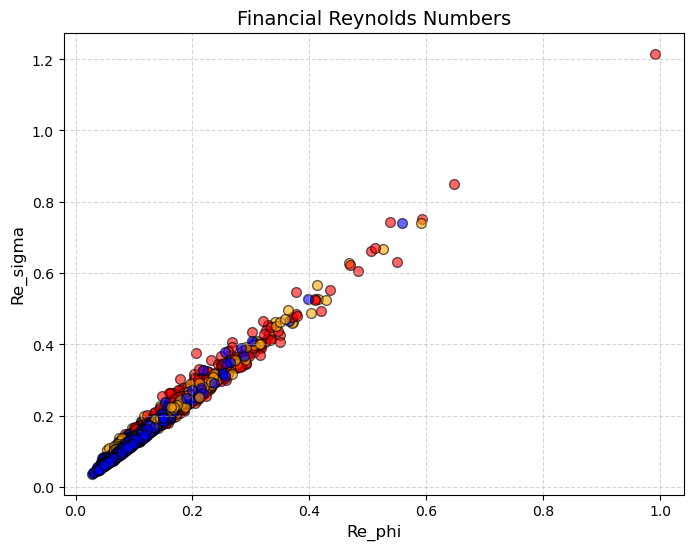

In [93]:
training_list_RC = [
            EminiSP500_roll_c, EminiNasdaq_roll_c, EminiNikkei_roll_c, 
            Gold_roll_c, Brent_roll_c, NGas_roll_c, Copper_roll_c, Wheat_roll_c,
            EurUsd_roll_c, UsdJpy_roll_c, UsdChf_roll_c, GbpUsd_roll_c, UsdCad_roll_c, UsdBrl_roll_c,
            Note10Y_roll_c
            ]

plot_reynolds_scatter(training_list_RC)

# Concatenate and keep the required columns
ml_df_RC = pd.concat(training_list_RC, ignore_index=True)
ml_df_RC = ml_df_RC[['Re_phi','Re_sigma','regime']].dropna()

#### Test Data

In [94]:
ml_start    = '2024-08-06'
ml_end      = '2025-08-06'
ml_window   = 90
ml_step     = 14
s_method    = 'roll'
thresh      = 'c'
low_thresh  = 1
high_thresh = 2

EminiSP500_roll_c_T    = generate_reynolds_dataset("ES=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNasdaq_roll_c_T   = generate_reynolds_dataset("NQ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNikkei_roll_c_T   = generate_reynolds_dataset("NIY=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Brent_roll_c_T    = generate_reynolds_dataset("BZ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
NGas_roll_c_T     = generate_reynolds_dataset("NG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Copper_roll_c_T   = generate_reynolds_dataset("HG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Gold_roll_c_T     = generate_reynolds_dataset("GC=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Wheat_roll_c_T    = generate_reynolds_dataset("ZW=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

EurUsd_roll_c_T   = generate_reynolds_dataset("EURUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdJpy_roll_c_T   = generate_reynolds_dataset("JPY=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdChf_roll_c_T   = generate_reynolds_dataset("USDCHF=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
GbpUsd_roll_c_T   = generate_reynolds_dataset("GBPUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdCad_roll_c_T   = generate_reynolds_dataset("USDCAD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdBrl_roll_c_T   = generate_reynolds_dataset("USDBRL=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Note10Y_roll_c_T    = generate_reynolds_dataset("ZN=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

In [95]:
testing_list_RC = [
    EminiSP500_roll_c_T, EminiNasdaq_roll_c_T, EminiNikkei_roll_c_T,
    Brent_roll_c_T, NGas_roll_c_T, Copper_roll_c_T, Gold_roll_c_T, Wheat_roll_c_T,
    EurUsd_roll_c_T, UsdJpy_roll_c_T, UsdChf_roll_c_T, GbpUsd_roll_c_T, UsdCad_roll_c_T, UsdBrl_roll_c_T, 
    Note10Y_roll_c_T
]

# Concatenate and keep the required columns
ml_df_RC_T = pd.concat(testing_list_RC, ignore_index=True)
ml_df_RC_T = ml_df_RC_T[['Re_phi','Re_sigma','regime']].dropna()

print(f"Rows: {ml_df_RC_T.shape[0]}, Columns: {ml_df_RC_T.shape[1]}")

Rows: 300, Columns: 3


### Hasb, Constant

#### Training Data

In [96]:
ml_start    = '2015-08-06'
ml_end      = '2024-08-06'
ml_window   = 90
ml_step     = 14
s_method    = 'hasb'
thresh      = 'c'
low_thresh  = 1
high_thresh = 2

EminiSP500_hasb_c   = generate_reynolds_dataset("ES=F", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)
EminiNasdaq_hasb_c   = generate_reynolds_dataset("NQ=F", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)
EminiNikkei_hasb_c   = generate_reynolds_dataset("NIY=F", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)


In [97]:
Brent_hasb_c    = generate_reynolds_dataset("BZ=F", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)
NGas_hasb_c     = generate_reynolds_dataset("NG=F", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)
Copper_hasb_c   = generate_reynolds_dataset("HG=F", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)
Gold_hasb_c     = generate_reynolds_dataset("GC=F", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)
Wheat_hasb_c    = generate_reynolds_dataset("ZW=F", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)

In [98]:
EurUsd_hasb_c   = generate_reynolds_dataset("EURUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)
UsdJpy_hasb_c   = generate_reynolds_dataset("JPY=X", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)
UsdChf_hasb_c   = generate_reynolds_dataset("USDCHF=X", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)
GbpUsd_hasb_c   = generate_reynolds_dataset("GBPUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)
UsdCad_hasb_c   = generate_reynolds_dataset("USDCAD=X", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)
UsdBrl_hasb_c   = generate_reynolds_dataset("USDBRL=X", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)

Note10Y_hasb_c   = generate_reynolds_dataset("ZN=F", ml_start, ml_end, ml_window, ml_step, s_method, 'c', 1, 2)

Total points plotted: 3435


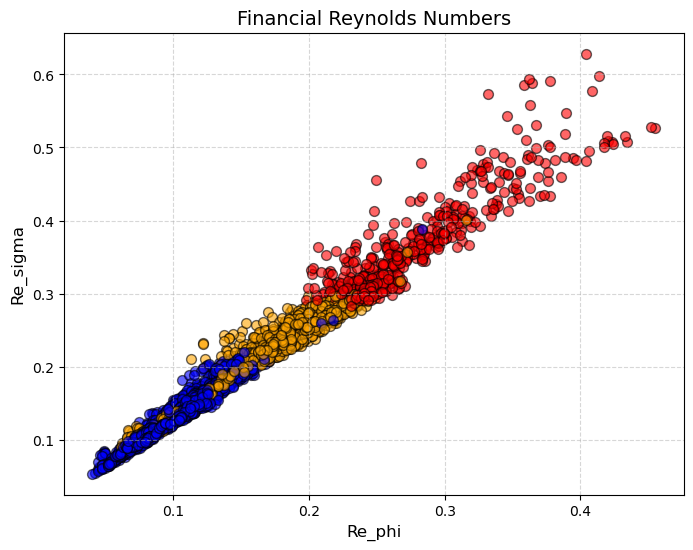

In [99]:
training_list_HC = [
            EminiSP500_hasb_c, EminiNasdaq_hasb_c, EminiNikkei_hasb_c, 
            Gold_hasb_c, Brent_hasb_c, NGas_hasb_c, Copper_hasb_c, Wheat_hasb_c,
            EurUsd_hasb_c, UsdJpy_hasb_c, UsdChf_hasb_c, GbpUsd_hasb_c, UsdCad_roll_c, UsdBrl_roll_c,
            Note10Y_hasb_c
            ]

plot_reynolds_scatter(training_list_HC)

# Concatenate and keep the required columns
ml_df_HC = pd.concat(training_list_HC, ignore_index=True)
ml_df_HC = ml_df_HC[['Re_phi','Re_sigma','regime']].dropna()

#### Test Data

In [100]:
ml_start    = '2024-08-06'
ml_end      = '2025-08-06'
ml_window   = 90
ml_step     = 14
s_method    = 'hasb'
thresh      = 'c'
low_thresh  = 1
high_thresh = 2

EminiSP500_hasb_c_T    = generate_reynolds_dataset("ES=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNasdaq_hasb_c_T   = generate_reynolds_dataset("NQ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNikkei_hasb_c_T   = generate_reynolds_dataset("NIY=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Brent_hasb_c_T    = generate_reynolds_dataset("BZ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
NGas_hasb_c_T     = generate_reynolds_dataset("NG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Copper_hasb_c_T   = generate_reynolds_dataset("HG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Gold_hasb_c_T     = generate_reynolds_dataset("GC=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Wheat_hasb_c_T    = generate_reynolds_dataset("ZW=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

In [101]:
EurUsd_hasb_c_T   = generate_reynolds_dataset("EURUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdJpy_hasb_c_T   = generate_reynolds_dataset("JPY=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdChf_hasb_c_T   = generate_reynolds_dataset("USDCHF=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
GbpUsd_hasb_c_T   = generate_reynolds_dataset("GBPUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdCad_hasb_c_T   = generate_reynolds_dataset("USDCAD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, 2)
UsdBrl_hasb_c_T   = generate_reynolds_dataset("USDBRL=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Note10Y_hasb_c_T    = generate_reynolds_dataset("ZN=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

In [102]:
testing_list_HC = [
    EminiSP500_hasb_c_T, EminiNasdaq_hasb_c_T, EminiNikkei_hasb_c_T,
    Brent_hasb_c_T, NGas_hasb_c_T, Copper_hasb_c_T, Gold_hasb_c_T, Wheat_hasb_c_T,
    EurUsd_hasb_c_T, UsdJpy_hasb_c_T, UsdChf_hasb_c_T, GbpUsd_hasb_c_T,
    UsdCad_hasb_c_T, UsdBrl_hasb_c_T, Note10Y_hasb_c_T
]

# Concatenate and keep the required columns
ml_df_HC_T = pd.concat(testing_list_HC, ignore_index=True)
ml_df_HC_T = ml_df_HC_T[['Re_phi','Re_sigma','regime']].dropna()

print(f"Rows: {ml_df_HC_T.shape[0]}, Columns: {ml_df_HC_T.shape[1]}")

Rows: 300, Columns: 3


### Roll, Quant

#### Training Data

In [ ]:
ml_start    = '2015-08-06'
ml_end      = '2024-08-06'
ml_window   = 90
ml_step     = 14
s_method    = 'roll'
thresh      = 'q'
low_thresh  = 0.1
high_thresh = 0.9

EminiSP500_roll_q    = generate_reynolds_dataset("ES=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNasdaq_roll_q   = generate_reynolds_dataset("NQ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNikkei_roll_q   = generate_reynolds_dataset("NIY=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Brent_roll_q    = generate_reynolds_dataset("BZ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
NGas_roll_q     = generate_reynolds_dataset("NG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Copper_roll_q   = generate_reynolds_dataset("HG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Gold_roll_q     = generate_reynolds_dataset("GC=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Wheat_roll_q    = generate_reynolds_dataset("ZW=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

EurUsd_roll_q   = generate_reynolds_dataset("EURUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdJpy_roll_q   = generate_reynolds_dataset("JPY=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdChf_roll_q   = generate_reynolds_dataset("USDCHF=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
GbpUsd_roll_q   = generate_reynolds_dataset("GBPUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdCad_roll_q   = generate_reynolds_dataset("USDCAD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdBrl_roll_q   = generate_reynolds_dataset("USDBRL=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Note10Y_roll_q   = generate_reynolds_dataset("ZN=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Total points plotted: 3435


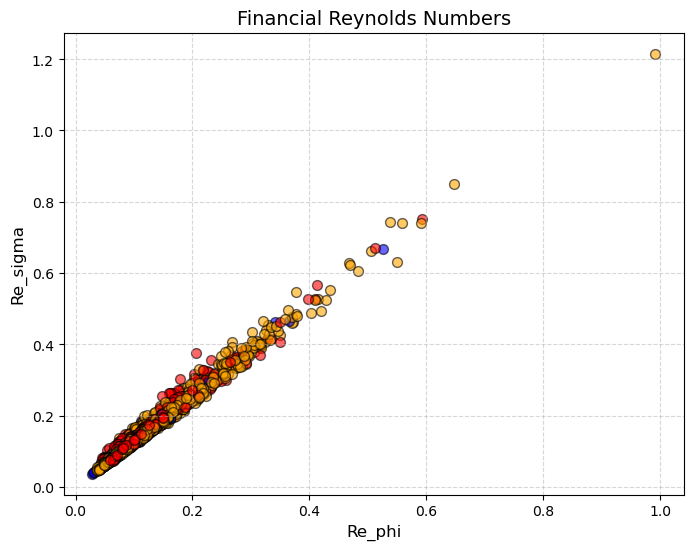

In [ ]:
training_list_RQ = [
            EminiSP500_roll_q, EminiNasdaq_roll_q, EminiNikkei_roll_q, 
            Gold_roll_q, Brent_roll_q, NGas_roll_q, Copper_roll_q, Wheat_roll_q,
            EurUsd_roll_q, UsdJpy_roll_q, UsdChf_roll_q, GbpUsd_roll_q, UsdCad_roll_q, UsdBrl_roll_q,
            Note10Y_roll_q
            ]

plot_reynolds_scatter(training_list_RQ)

# Concatenate and keep the required columns
ml_df_RQ = pd.concat(training_list_RQ, ignore_index=True)
ml_df_RQ = ml_df_RQ[['Re_phi','Re_sigma','regime']].dropna()

#### Test Data

In [ ]:
ml_start    = '2024-08-06'
ml_end      = '2025-08-06'
ml_window   = 90
ml_step     = 14
s_method    = 'roll'
thresh      = 'q'
low_thresh  = 0.1
high_thresh = 0.9

EminiSP500_roll_q_T    = generate_reynolds_dataset("ES=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNasdaq_roll_q_T   = generate_reynolds_dataset("NQ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNikkei_roll_q_T   = generate_reynolds_dataset("NIY=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Brent_roll_q_T    = generate_reynolds_dataset("BZ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
NGas_roll_q_T     = generate_reynolds_dataset("NG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Copper_roll_q_T   = generate_reynolds_dataset("HG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Gold_roll_q_T     = generate_reynolds_dataset("GC=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Wheat_roll_q_T    = generate_reynolds_dataset("ZW=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

EurUsd_roll_q_T   = generate_reynolds_dataset("EURUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdJpy_roll_q_T   = generate_reynolds_dataset("JPY=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdChf_roll_q_T   = generate_reynolds_dataset("USDCHF=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
GbpUsd_roll_q_T   = generate_reynolds_dataset("GBPUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdCad_roll_q_T   = generate_reynolds_dataset("USDCAD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdBrl_roll_q_T   = generate_reynolds_dataset("USDBRL=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Note10Y_roll_q_T    = generate_reynolds_dataset("ZN=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

In [ ]:
testing_list_RQ = [
    EminiSP500_roll_q_T, EminiNasdaq_roll_q_T, EminiNikkei_roll_q_T,
    Brent_roll_q_T, NGas_roll_q_T, Copper_roll_q_T, Gold_roll_q_T, Wheat_roll_q_T,
    EurUsd_roll_q_T, UsdJpy_roll_q_T, UsdChf_roll_q_T, GbpUsd_roll_q_T, UsdCad_roll_q_T, UsdBrl_roll_q_T, 
    Note10Y_roll_q_T
]

# Concatenate and keep the required columns
ml_df_RQ_T = pd.concat(testing_list_RQ, ignore_index=True)
ml_df_RQ_T = ml_df_RQ_T[['Re_phi','Re_sigma','regime']].dropna()

print(f"Rows: {ml_df_RQ_T.shape[0]}, Columns: {ml_df_RQ_T.shape[1]}")

Rows: 300, Columns: 3


### Hasb, Quant

#### Training Data

In [ ]:
ml_start    = '2015-08-06'
ml_end      = '2024-08-06'
ml_window   = 90
ml_step     = 14
s_method    = 'hasb'
thresh      = 'q'
low_thresh  = 0.1
high_thresh = 0.9

EminiSP500_hasb_q    = generate_reynolds_dataset("ES=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNasdaq_hasb_q   = generate_reynolds_dataset("NQ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNikkei_hasb_q   = generate_reynolds_dataset("NIY=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

In [ ]:
Brent_hasb_q    = generate_reynolds_dataset("BZ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
NGas_hasb_q     = generate_reynolds_dataset("NG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Copper_hasb_q   = generate_reynolds_dataset("HG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Gold_hasb_q     = generate_reynolds_dataset("GC=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Wheat_hasb_q    = generate_reynolds_dataset("ZW=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

In [ ]:
EurUsd_hasb_q   = generate_reynolds_dataset("EURUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdJpy_hasb_q   = generate_reynolds_dataset("JPY=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdChf_hasb_q   = generate_reynolds_dataset("USDCHF=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
GbpUsd_hasb_q   = generate_reynolds_dataset("GBPUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdCad_hasb_q   = generate_reynolds_dataset("USDCAD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdBrl_hasb_q   = generate_reynolds_dataset("USDBRL=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Note10Y_hasb_q   = generate_reynolds_dataset("ZN=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Total points plotted: 3435


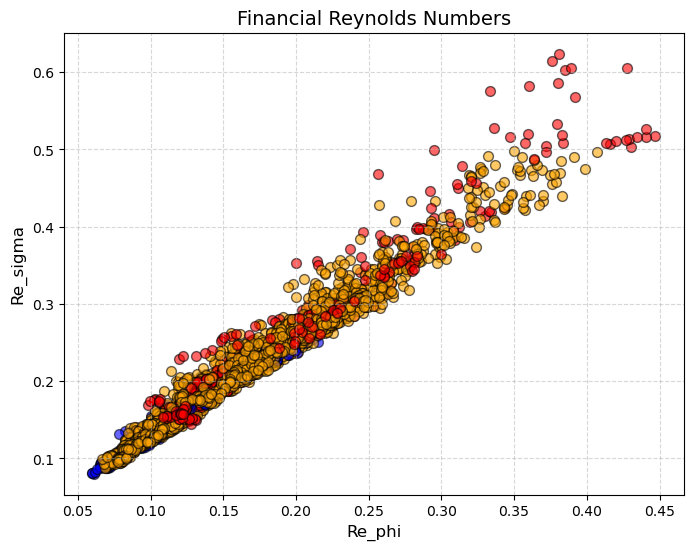

In [ ]:
training_list_HQ = [
            EminiSP500_hasb_q, EminiNasdaq_hasb_q, EminiNikkei_hasb_q, 
            Gold_hasb_q, Brent_hasb_q, NGas_hasb_q, Copper_hasb_q, Wheat_hasb_q,
            EurUsd_hasb_q, UsdJpy_hasb_q, UsdChf_hasb_q, GbpUsd_hasb_q, UsdCad_hasb_q, UsdBrl_hasb_q,
            Note10Y_hasb_q
            ]

plot_reynolds_scatter(training_list_HQ)

# Concatenate and keep the required columns
ml_df_HQ = pd.concat(training_list_HQ, ignore_index=True)
ml_df_HQ = ml_df_HQ[['Re_phi','Re_sigma','regime']].dropna()

#### Test Data

In [ ]:
ml_start    = '2024-08-06'
ml_end      = '2025-08-06'
ml_window   = 90
ml_step     = 14
s_method    = 'hasb'
thresh      = 'q'
low_thresh  = 0.1
high_thresh = 0.9

EminiSP500_hasb_q_T    = generate_reynolds_dataset("ES=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNasdaq_hasb_q_T   = generate_reynolds_dataset("NQ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
EminiNikkei_hasb_q_T   = generate_reynolds_dataset("NIY=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Brent_hasb_q_T    = generate_reynolds_dataset("BZ=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
NGas_hasb_q_T     = generate_reynolds_dataset("NG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Copper_hasb_q_T   = generate_reynolds_dataset("HG=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Gold_hasb_q_T     = generate_reynolds_dataset("GC=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
Wheat_hasb_q_T    = generate_reynolds_dataset("ZW=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

In [ ]:
EurUsd_hasb_q_T   = generate_reynolds_dataset("EURUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdJpy_hasb_q_T   = generate_reynolds_dataset("JPY=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdChf_hasb_q_T   = generate_reynolds_dataset("USDCHF=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
GbpUsd_hasb_q_T   = generate_reynolds_dataset("GBPUSD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdCad_hasb_q_T   = generate_reynolds_dataset("USDCAD=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)
UsdBrl_hasb_q_T   = generate_reynolds_dataset("USDBRL=X", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

Note10Y_hasb_q_T   = generate_reynolds_dataset("ZN=F", ml_start, ml_end, ml_window, ml_step, s_method, thresh, low_thresh, high_thresh)

In [ ]:
testing_list_HQ = [
            EminiSP500_hasb_q_T, EminiNasdaq_hasb_q_T, EminiNikkei_hasb_q_T, 
            Gold_hasb_q_T, Brent_hasb_q_T, NGas_hasb_q_T, Copper_hasb_q_T, Wheat_hasb_q_T,
            EurUsd_hasb_q_T, UsdJpy_hasb_q_T, UsdChf_hasb_q_T, GbpUsd_hasb_q_T, UsdCad_hasb_q_T, UsdBrl_hasb_q_T,
            Note10Y_hasb_q_T
            ]

# Concatenate and keep the required columns
ml_df_HQ_T = pd.concat(testing_list_HQ, ignore_index=True)
ml_df_HQ_T = ml_df_HQ_T[['Re_phi','Re_sigma','regime']].dropna()

print(f"Rows: {ml_df_HQ_T.shape[0]}, Columns: {ml_df_HQ_T.shape[1]}")

Rows: 300, Columns: 3


#### Graphs

In [ ]:
def plot_reynolds_scatter(df_list, labels=None):
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(df_list))]

    # Combine into one DataFrame, add a source label for each
    all_df = []
    for df, label in zip(df_list, labels):
        temp = df.copy()
        temp['source'] = label
        all_df.append(temp)
    combined_df = pd.concat(all_df, ignore_index=True)

    # Define regimes and colors
    regimes = ['laminar', 'transitional', 'turbulent']
    cmap = plt.cm.viridis
    regime_to_color = {reg: cmap(i) for reg, i in zip(regimes, np.linspace(0, 1, len(regimes)))}

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(8, 6))

    # Background gray points (all data, no regime filter)
    ax.scatter(combined_df['Re_phi'], combined_df['Re_sigma'],
               s=8, color="#DADDE1", alpha=0.4, zorder=1)

    # Overlay colored points by regime
    for reg in regimes:
        d = combined_df[combined_df['regime'] == reg]
        ax.scatter(d['Re_phi'], d['Re_sigma'],
                   s=12, alpha=0.6, color=regime_to_color[reg],
                   zorder=2, label=reg)

    # Labels
    ax.set_xlabel(r"$\mathrm{Re}_{\Phi}$", fontsize=13)
    ax.set_ylabel(r"$\mathrm{Re}_{\sigma}$", fontsize=13)

    # Clean style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle="--", alpha=0.3)

    # Optional legend (remove for thesis-style clean plots)
    # ax.legend(title="", loc="upper left", frameon=False)

    # Report total points
    print(f"Total points plotted: {len(combined_df)}")

    fig.tight_layout()
    plt.show()

Total points plotted: 3435


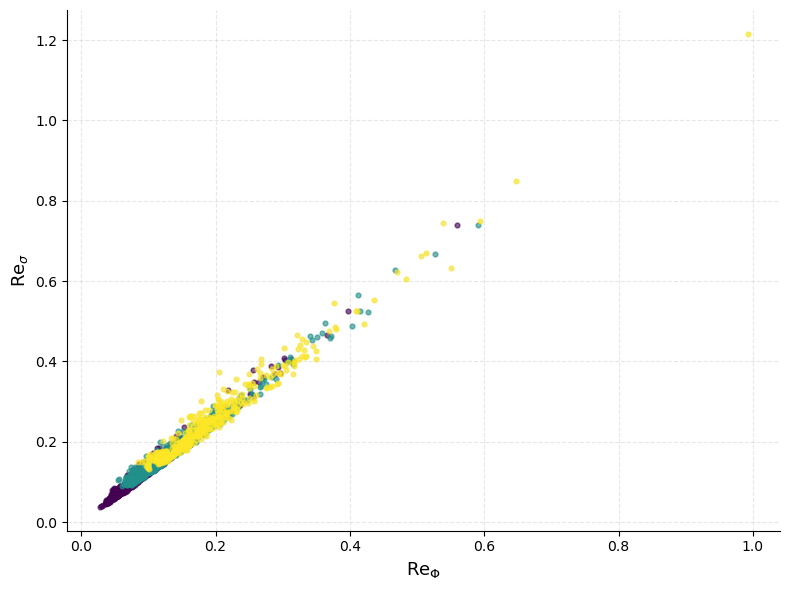

Total points plotted: 3435


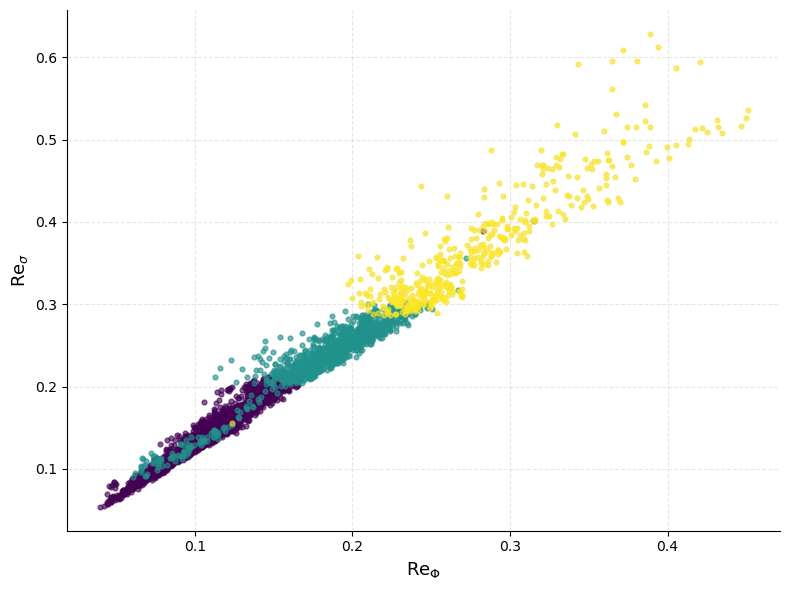

Total points plotted: 3435


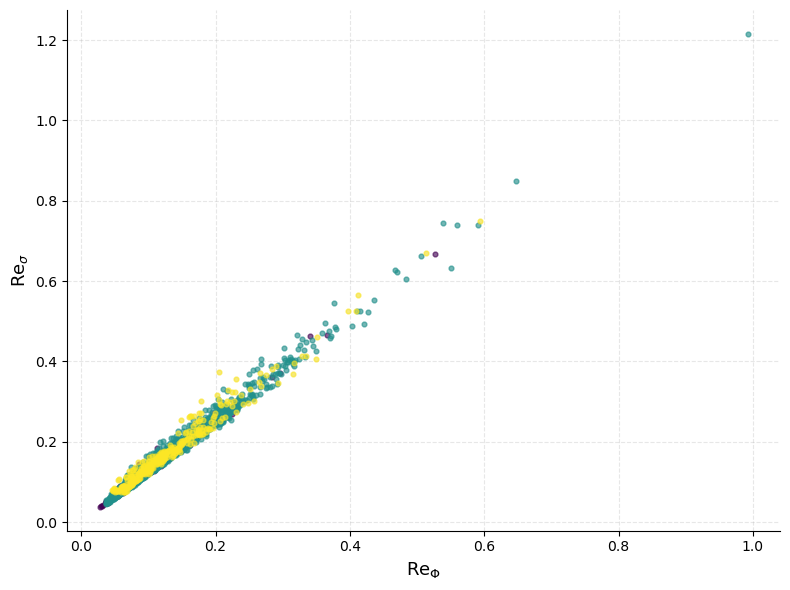

Total points plotted: 3435


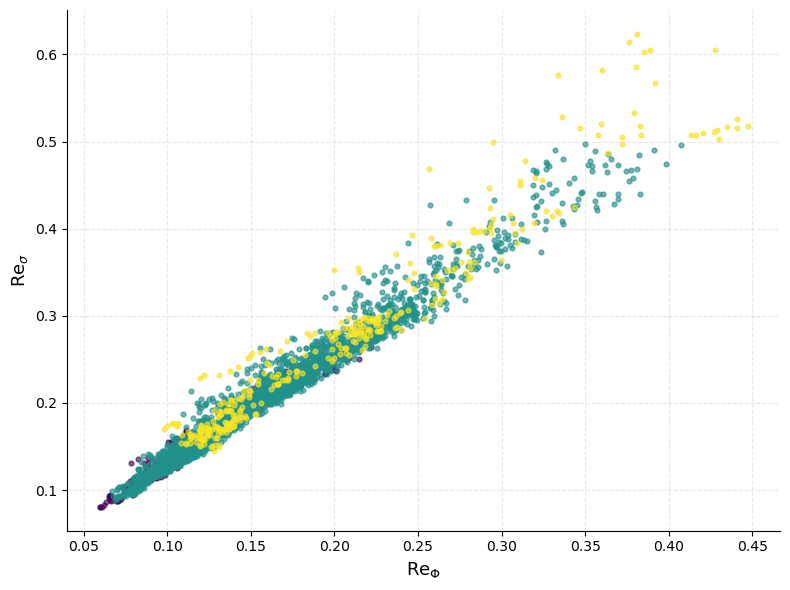

In [ ]:
plot_reynolds_scatter(training_list_RC)
plot_reynolds_scatter(training_list_HC)
plot_reynolds_scatter(training_list_RQ)
plot_reynolds_scatter(training_list_HQ)

## K-nearest neighbour

### Formula

In [ ]:
def prepare_ml_table(df_list):
    """Concatenate, drop NaNs, keep only the needed columns."""
    df = pd.concat(df_list, ignore_index=True)
    df = df[['Re_phi','Re_sigma','regime']].dropna()
    # encode labels as integers for scikit-learn (optional, KNN can handle strings too)
    df = df[df['regime'].isin(['laminar','transitional','turbulent'])].copy()
    return df

def train_knn(df_list, test_size=0.25, random_state=42):
    """Train/evaluate a KNN classifier; returns best model, scaler, and eval artifacts."""
    df = prepare_ml_table(df_list)
    X = df[['Re_phi','Re_sigma']].values
    y = df['regime'].values

    # split (stratified to preserve class proportions)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # scale features (very important for distance-based models like KNN)
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # hyperparameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance']
    }

    knn = KNeighborsClassifier()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    grid = GridSearchCV(knn, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train_s, y_train)

    best_knn = grid.best_estimator_

    # evaluation on holdout set
    y_pred = best_knn.predict(X_test_s)
    cm = confusion_matrix(y_test, y_pred, labels=['laminar','transitional','turbulent'])
    report = classification_report(y_test, y_pred, digits=3)

    # package results
    results = {
        'best_params': grid.best_params_,
        'cv_best_score_f1_macro': grid.best_score_,
        'confusion_matrix_labels': ['laminar','transitional','turbulent'],
        'confusion_matrix': cm,
        'classification_report': report,
        'n_train': len(y_train),
        'n_test': len(y_test)
    }

    return best_knn, scaler, results

### Roll Const

In [ ]:
# Features (X) and labels (y)
X = ml_df_RC[['Re_phi','Re_sigma']].values
y = ml_df_RC['regime'].values  # strings are fine for sklearn

# Stratified split to preserve class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Scale features (important for distance-based KNN)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# KNN hyperparameter search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(knn, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train_s, y_train)

best_knn = grid.best_estimator_
print("Best KNN params:", grid.best_params_)
print("CV best (macro F1):", grid.best_score_)

Best KNN params: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
CV best (macro F1): 0.6363830569741495


In [ ]:
# ===== 3) Evaluate on the holdout set =================================
y_pred = best_knn.predict(X_test_s)
print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred, labels=['laminar','transitional','turbulent']))

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Confusion matrix (rows=true, cols=pred):
[[404  76  11]
 [ 89 137  33]
 [  3  51  55]]

Classification report:
              precision    recall  f1-score   support

     laminar      0.815     0.823     0.819       491
transitional      0.519     0.529     0.524       259
   turbulent      0.556     0.505     0.529       109

    accuracy                          0.694       859
   macro avg      0.630     0.619     0.624       859
weighted avg      0.693     0.694     0.693       859



In [ ]:
# Concatenate all new testing DataFrames
ml_df_RC_T = pd.concat(testing_list_RC, ignore_index=True)

# Keep only the feature columns
X_new = ml_df_RC_T[['Re_phi', 'Re_sigma']].values
X_new_s = scaler.transform(X_new)

In [ ]:
predictions = best_knn.predict(X_new_s)
ml_df_RC_T['predicted_regime'] = predictions

print(ml_df_RC_T['predicted_regime'].value_counts())

predicted_regime
laminar         175
transitional     89
turbulent        36
Name: count, dtype: int64


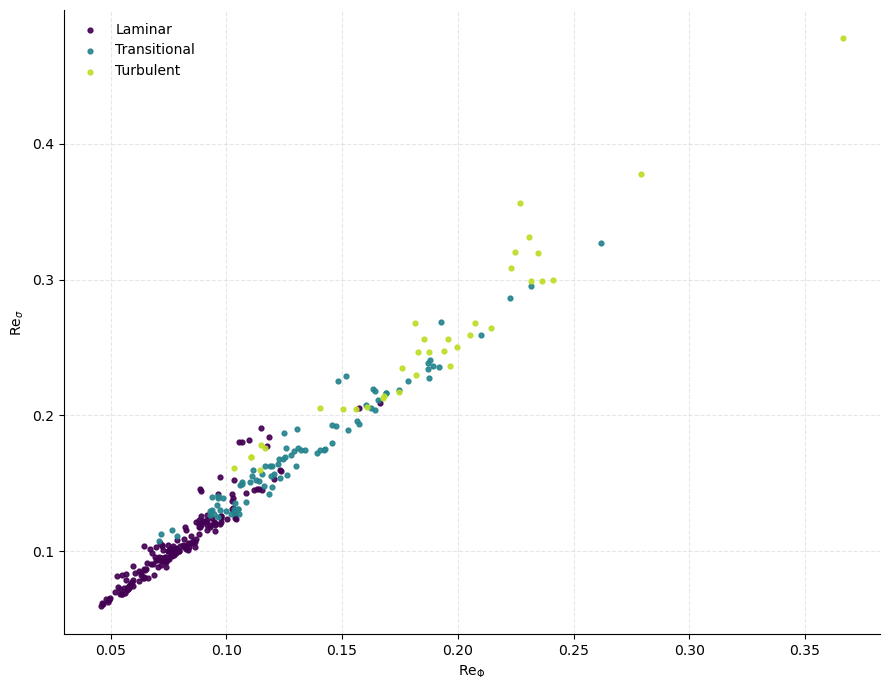

In [ ]:
# --- Regimes and colormap ---
regimes = ["Laminar", "Transitional", "Turbulent"]
cmap = plt.cm.viridis
palette = {r: cmap(t) for r, t in zip(regimes, np.linspace(0, 0.9, len(regimes)))}

# --- Prepare data ---
df = ml_df_RC_T.copy()                                                                      ##### CHANGE HERE #####
df["predicted_regime"] = df["predicted_regime"].str.capitalize()

xcol, ycol, hcol = "Re_phi", "Re_sigma", "predicted_regime"

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 7))

# Background gray points
ax.scatter(df[xcol], df[ycol], s=8, color="#DADDE1", alpha=0.4, zorder=1)

# Colored points by regime
for reg in regimes:
    d = df[df[hcol] == reg]
    ax.scatter(d[xcol], d[ycol], s=12, alpha=0.9, color=palette[reg], zorder=2, label=reg)

# Labels
ax.set_xlabel(r"$\mathrm{Re}_{\Phi}$")
ax.set_ylabel(r"$\mathrm{Re}_{\sigma}$")

# Clean look (no top/right spines, subtle grid)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.3)

# Legend (if you want it removed, comment these two lines)
ax.legend(loc="upper left", frameon=False)

fig.tight_layout()
plt.show()

### Hasb Const

In [ ]:
# Features (X) and labels (y)
X = ml_df_HC[['Re_phi','Re_sigma']].values
y = ml_df_HC['regime'].values  # strings are fine for sklearn

# Stratified split to preserve class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Scale features (important for distance-based KNN)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# KNN hyperparameter search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(knn, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train_s, y_train)

best_knn = grid.best_estimator_
print("Best KNN params:", grid.best_params_)
print("CV best (macro F1):", grid.best_score_)

Best KNN params: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
CV best (macro F1): 0.9402996834241097


In [ ]:
# ===== 3) Evaluate on the holdout set =================================
y_pred = best_knn.predict(X_test_s)
print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred, labels=['laminar','transitional','turbulent']))

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Confusion matrix (rows=true, cols=pred):
[[481  10   0]
 [ 30 222   7]
 [  1   2 106]]

Classification report:
              precision    recall  f1-score   support

     laminar      0.939     0.980     0.959       491
transitional      0.949     0.857     0.901       259
   turbulent      0.938     0.972     0.955       109

    accuracy                          0.942       859
   macro avg      0.942     0.936     0.938       859
weighted avg      0.942     0.942     0.941       859



In [ ]:
# Keep only the feature columns
X_new = ml_df_HC_T[['Re_phi', 'Re_sigma']].values
X_new_s = scaler.transform(X_new)

predictions = best_knn.predict(X_new_s)
ml_df_HC_T['predicted_regime'] = predictions

print(ml_df_HC_T['predicted_regime'].value_counts())

predicted_regime
laminar         152
transitional    101
turbulent        47
Name: count, dtype: int64


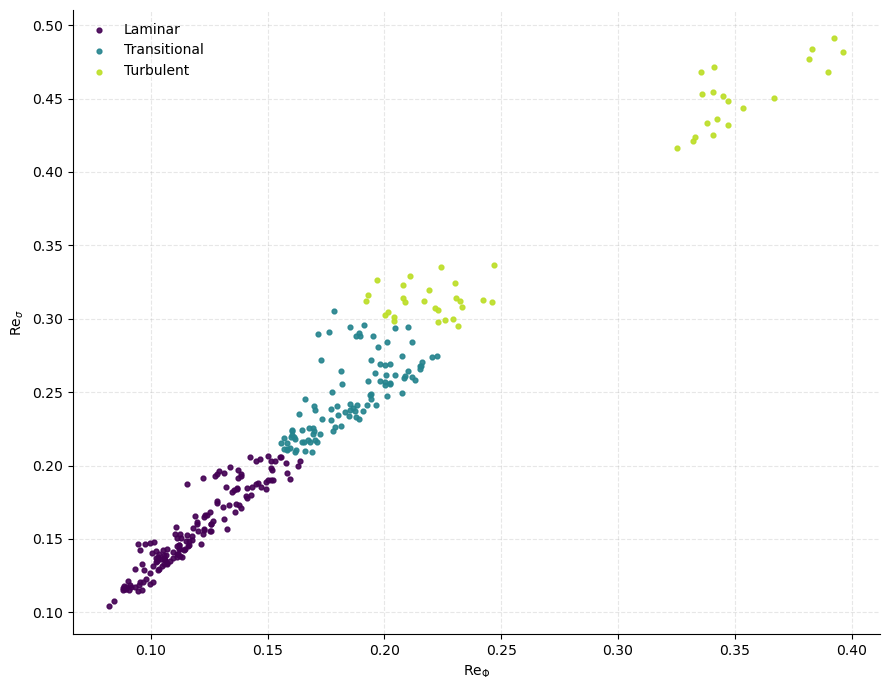

In [ ]:
# --- Regimes and colormap ---
regimes = ["Laminar", "Transitional", "Turbulent"]
cmap = plt.cm.viridis
palette = {r: cmap(t) for r, t in zip(regimes, np.linspace(0, 0.9, len(regimes)))}

# --- Prepare data ---
df = ml_df_HC_T.copy()                                                                      ##### CHANGE HERE #####
df["predicted_regime"] = df["predicted_regime"].str.capitalize()

xcol, ycol, hcol = "Re_phi", "Re_sigma", "predicted_regime"

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 7))

# Background gray points
ax.scatter(df[xcol], df[ycol], s=8, color="#DADDE1", alpha=0.4, zorder=1)

# Colored points by regime
for reg in regimes:
    d = df[df[hcol] == reg]
    ax.scatter(d[xcol], d[ycol], s=12, alpha=0.9, color=palette[reg], zorder=2, label=reg)

# Labels
ax.set_xlabel(r"$\mathrm{Re}_{\Phi}$")
ax.set_ylabel(r"$\mathrm{Re}_{\sigma}$")

# Clean look (no top/right spines, subtle grid)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.3)

# Legend (if you want it removed, comment these two lines)
ax.legend(loc="upper left", frameon=False)

fig.tight_layout()
plt.show()

### Roll Quant

In [ ]:
# Features (X) and labels (y)
X = ml_df_RQ[['Re_phi','Re_sigma']].values
y = ml_df_RQ['regime'].values  # strings are fine for sklearn

# Stratified split to preserve class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Scale features (important for distance-based KNN)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# KNN hyperparameter search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(knn, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train_s, y_train)

best_knn = grid.best_estimator_
print("Best KNN params:", grid.best_params_)
print("CV best (macro F1):", grid.best_score_)

Best KNN params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
CV best (macro F1): 0.3737999462158994


In [ ]:
# ===== 3) Evaluate on the holdout set =================================
y_pred = best_knn.predict(X_test_s)
print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred, labels=['laminar','transitional','turbulent']))

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Confusion matrix (rows=true, cols=pred):
[[ 11  74   1]
 [ 55 612  20]
 [  3  75   8]]

Classification report:
              precision    recall  f1-score   support

     laminar      0.159     0.128     0.142        86
transitional      0.804     0.891     0.845       687
   turbulent      0.276     0.093     0.139        86

    accuracy                          0.735       859
   macro avg      0.413     0.371     0.375       859
weighted avg      0.687     0.735     0.704       859



In [ ]:
# Keep only the feature columns
X_new = ml_df_RQ_T[['Re_phi', 'Re_sigma']].values
X_new_s = scaler.transform(X_new)

predictions = best_knn.predict(X_new_s)
ml_df_RQ_T['predicted_regime'] = predictions

print(ml_df_RQ_T['predicted_regime'].value_counts())

predicted_regime
transitional    266
laminar          22
turbulent        12
Name: count, dtype: int64


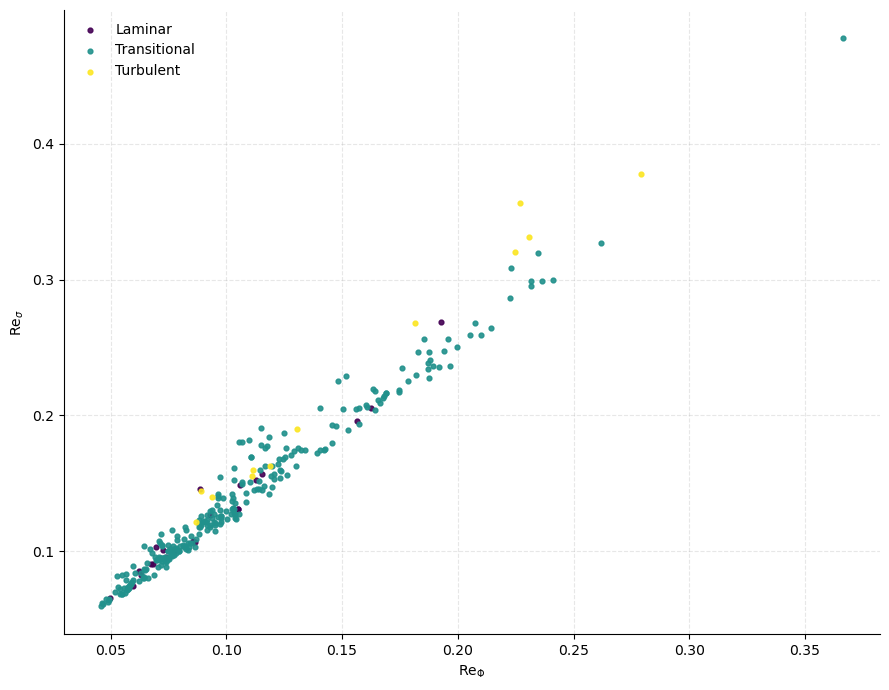

In [ ]:
# --- Regimes and colormap ---
regimes = ["Laminar", "Transitional", "Turbulent"]
cmap = plt.cm.viridis
palette = {r: cmap(t) for r, t in zip(regimes, np.linspace(0, 1, len(regimes)))}

# --- Prepare data ---
df = ml_df_RQ_T.copy()                                                                      ##### CHANGE HERE #####
df["predicted_regime"] = df["predicted_regime"].str.capitalize()

xcol, ycol, hcol = "Re_phi", "Re_sigma", "predicted_regime"

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 7))

# Background gray points
ax.scatter(df[xcol], df[ycol], s=8, color="#DADDE1", alpha=0.4, zorder=1)

# Colored points by regime
for reg in regimes:
    d = df[df[hcol] == reg]
    ax.scatter(d[xcol], d[ycol], s=12, alpha=0.9, color=palette[reg], zorder=2, label=reg)

# Labels
ax.set_xlabel(r"$\mathrm{Re}_{\Phi}$")
ax.set_ylabel(r"$\mathrm{Re}_{\sigma}$")

# Clean look (no top/right spines, subtle grid)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.3)

# Legend (if you want it removed, comment these two lines)
ax.legend(loc="upper left", frameon=False)

fig.tight_layout()
plt.show()

### Hasb Quant

In [ ]:
# Features (X) and labels (y)
X = ml_df_HQ[['Re_phi','Re_sigma']].values
y = ml_df_HQ['regime'].values  # strings are fine for sklearn

# Stratified split to preserve class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Scale features (important for distance-based KNN)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# KNN hyperparameter search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(knn, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train_s, y_train)

best_knn = grid.best_estimator_
print("Best KNN params:", grid.best_params_)
print("CV best (macro F1):", grid.best_score_)

Best KNN params: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
CV best (macro F1): 0.4984925008026423


In [ ]:
# ===== 3) Evaluate on the holdout set =================================
y_pred = best_knn.predict(X_test_s)
print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred, labels=['laminar','transitional','turbulent']))

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Confusion matrix (rows=true, cols=pred):
[[ 24  61   1]
 [ 26 636  25]
 [  3  59  24]]

Classification report:
              precision    recall  f1-score   support

     laminar      0.453     0.279     0.345        86
transitional      0.841     0.926     0.881       687
   turbulent      0.480     0.279     0.353        86

    accuracy                          0.796       859
   macro avg      0.591     0.495     0.527       859
weighted avg      0.766     0.796     0.775       859



In [ ]:
# Keep only the feature columns
X_new = ml_df_HQ_T[['Re_phi', 'Re_sigma']].values
X_new_s = scaler.transform(X_new)

predictions = best_knn.predict(X_new_s)
ml_df_HQ_T['predicted_regime'] = predictions

print(ml_df_HQ_T['predicted_regime'].value_counts())

predicted_regime
transitional    277
turbulent        15
laminar           8
Name: count, dtype: int64


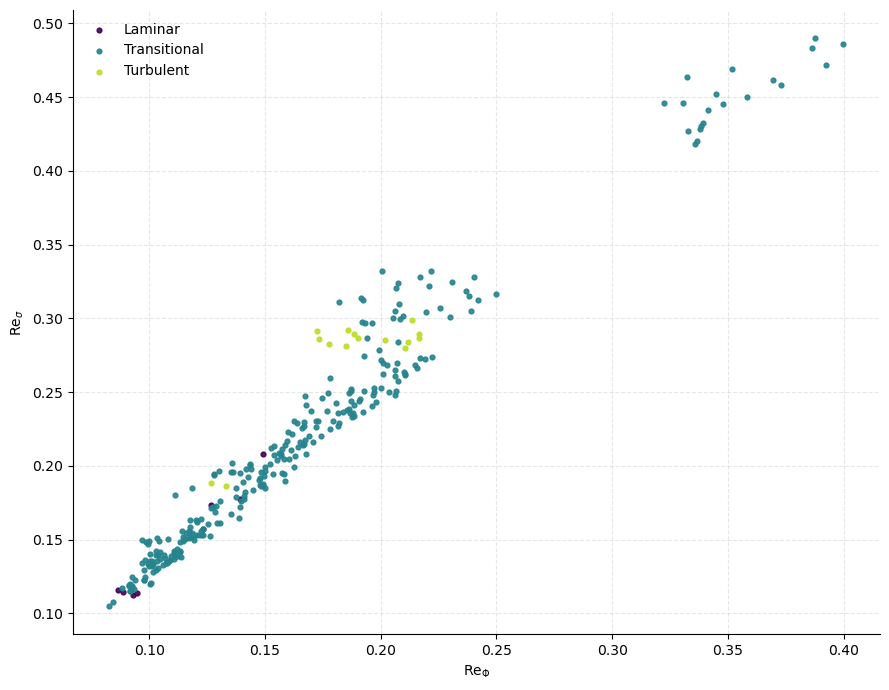

In [ ]:
# --- Regimes and colormap ---
regimes = ["Laminar", "Transitional", "Turbulent"]
cmap = plt.cm.viridis
palette = {r: cmap(t) for r, t in zip(regimes, np.linspace(0, 0.9, len(regimes)))}

# --- Prepare data ---
df = ml_df_HQ_T.copy()                                                                      ##### CHANGE HERE #####
df["predicted_regime"] = df["predicted_regime"].str.capitalize()

xcol, ycol, hcol = "Re_phi", "Re_sigma", "predicted_regime"

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 7))

# Background gray points
ax.scatter(df[xcol], df[ycol], s=8, color="#DADDE1", alpha=0.4, zorder=1)

# Colored points by regime
for reg in regimes:
    d = df[df[hcol] == reg]
    ax.scatter(d[xcol], d[ycol], s=12, alpha=0.9, color=palette[reg], zorder=2, label=reg)

# Labels
ax.set_xlabel(r"$\mathrm{Re}_{\Phi}$")
ax.set_ylabel(r"$\mathrm{Re}_{\sigma}$")

# Clean look (no top/right spines, subtle grid)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.3)

# Legend (if you want it removed, comment these two lines)
ax.legend(loc="upper left", frameon=False)

fig.tight_layout()
plt.show()

## SVM

### Formulas

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

def prepare_ml_table(df_list):
    df = pd.concat(df_list, ignore_index=True)
    df = df[['Re_phi','Re_sigma','regime']].dropna()
    df = df[df['regime'].isin(['laminar','transitional','turbulent'])].copy()
    return df

def train_svm(df_list, test_size=0.25, random_state=42, class_weight=None):
    """
    Train/evaluate an SVM classifier on Re_phi & Re_sigma.
    Returns: best_model, scaler, results_dict
    """
    df = prepare_ml_table(df_list)
    X = df[['Re_phi','Re_sigma']].values
    y = df['regime'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Grid: linear and RBF kernels
    param_grid = [
        {'kernel':['linear'], 'C':[0.1, 1, 10, 100]},
        {'kernel':['rbf'],    'C':[0.1, 1, 10, 100], 'gamma':['scale','auto', 0.01, 0.1, 1.0]},
    ]

    svm = SVC(probability=True, class_weight=class_weight)  # set class_weight='balanced' if classes imbalanced
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    grid = GridSearchCV(svm, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train_s, y_train)

    best_svm = grid.best_estimator_

    # Hold‑out evaluation
    y_pred = best_svm.predict(X_test_s)
    cm = confusion_matrix(y_test, y_pred, labels=['laminar','transitional','turbulent'])
    report = classification_report(y_test, y_pred, digits=3)

    results = {
        'best_params': grid.best_params_,
        'cv_best_score_f1_macro': grid.best_score_,
        'confusion_matrix_labels': ['laminar','transitional','turbulent'],
        'confusion_matrix': cm,
        'classification_report': report,
        'n_train': len(y_train),
        'n_test': len(y_test)
    }
    return best_svm, scaler, results

### Roll Const

In [ ]:
best_svm, scaler_svm, res_svm = train_svm(training_list_RC, test_size=0.25, class_weight='balanced')
print("Best SVM params:", res_svm['best_params'])
print("CV best (macro F1):", res_svm['cv_best_score_f1_macro'])
print(res_svm['classification_report'])

Best SVM params: {'C': 0.1, 'kernel': 'linear'}
CV best (macro F1): 0.6701271084537874
              precision    recall  f1-score   support

     laminar      0.876     0.809     0.841       491
transitional      0.552     0.591     0.571       259
   turbulent      0.504     0.596     0.546       109

    accuracy                          0.716       859
   macro avg      0.644     0.665     0.653       859
weighted avg      0.731     0.716     0.722       859



In [ ]:
# Concatenate your new testing DataFrames
ml_df_RC_T = pd.concat(testing_list_RC, ignore_index=True)

# Predict with trained SVM
X_new   = ml_df_RC_T[['Re_phi','Re_sigma']].values
X_new_s = scaler_svm.transform(X_new)
svm_preds = best_svm.predict(X_new_s)
svm_probs = best_svm.predict_proba(X_new_s)   # optional: class probabilities

ml_df_RC_T['predicted_regime_svm'] = svm_preds
print(ml_df_RC_T['predicted_regime_svm'].value_counts())

predicted_regime_svm
laminar         147
transitional     98
turbulent        55
Name: count, dtype: int64


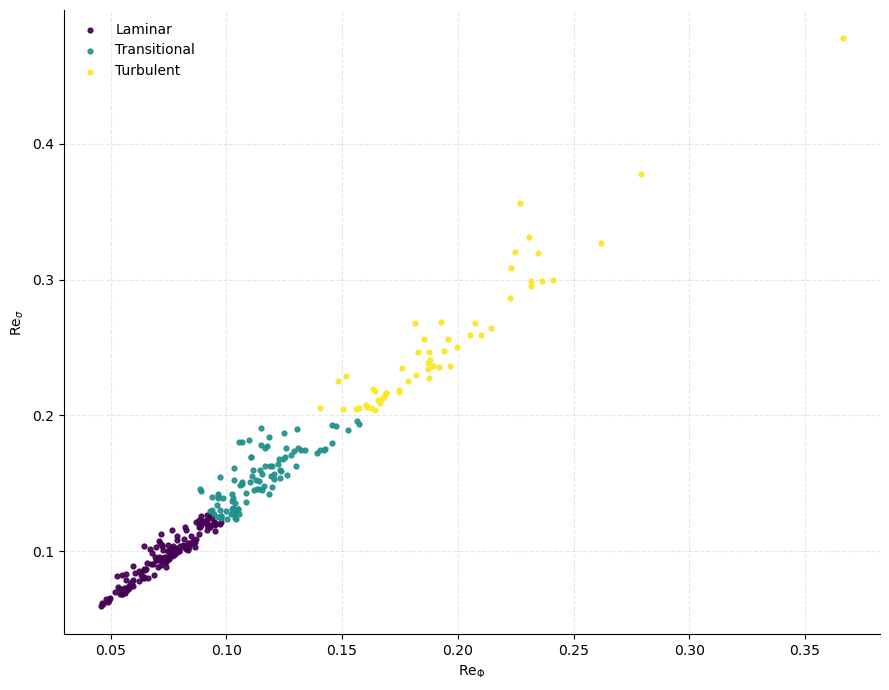

In [ ]:
# --- Regimes and colormap ---
regimes = ["Laminar", "Transitional", "Turbulent"]
cmap = plt.cm.viridis
palette = {r: cmap(t) for r, t in zip(regimes, np.linspace(0, 1, len(regimes)))}

# --- Prepare data ---
df = ml_df_RC_T.copy()                                                                      ##### CHANGE HERE #####
df["predicted_regime_svm"] = df["predicted_regime_svm"].str.capitalize()

xcol, ycol, hcol = "Re_phi", "Re_sigma", "predicted_regime_svm"

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 7))

# Background gray points
ax.scatter(df[xcol], df[ycol], s=8, color="#DADDE1", alpha=0.4, zorder=1)

# Colored points by regime
for reg in regimes:
    d = df[df[hcol] == reg]
    ax.scatter(d[xcol], d[ycol], s=12, alpha=0.9, color=palette[reg], zorder=2, label=reg)

# Labels
ax.set_xlabel(r"$\mathrm{Re}_{\Phi}$")
ax.set_ylabel(r"$\mathrm{Re}_{\sigma}$")

# Clean look (no top/right spines, subtle grid)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.3)

# Legend (if you want it removed, comment these two lines)
ax.legend(loc="upper left", frameon=False)

fig.tight_layout()
plt.show()

### Hasb Const

In [ ]:
best_svm, scaler_svm, res_svm = train_svm(training_list_HC, test_size=0.25, class_weight='balanced')
print("Best SVM params:", res_svm['best_params'])
print("CV best (macro F1):", res_svm['cv_best_score_f1_macro'])
print(res_svm['classification_report'])

Best SVM params: {'C': 100, 'gamma': 1.0, 'kernel': 'rbf'}
CV best (macro F1): 0.9356422224838941
              precision    recall  f1-score   support

     laminar      0.945     0.982     0.963       491
transitional      0.953     0.865     0.907       259
   turbulent      0.930     0.972     0.951       109

    accuracy                          0.945       859
   macro avg      0.943     0.940     0.940       859
weighted avg      0.946     0.945     0.945       859



In [ ]:
# Concatenate your new testing DataFrames
ml_df_HC_T = pd.concat(testing_list_HC, ignore_index=True)

# Predict with trained SVM
X_new   = ml_df_HC_T[['Re_phi','Re_sigma']].values
X_new_s = scaler_svm.transform(X_new)
svm_preds = best_svm.predict(X_new_s)
svm_probs = best_svm.predict_proba(X_new_s)   # optional: class probabilities

ml_df_HC_T['predicted_regime_svm'] = svm_preds
print(ml_df_HC_T['predicted_regime_svm'].value_counts())

predicted_regime_svm
laminar         148
transitional    100
turbulent        52
Name: count, dtype: int64


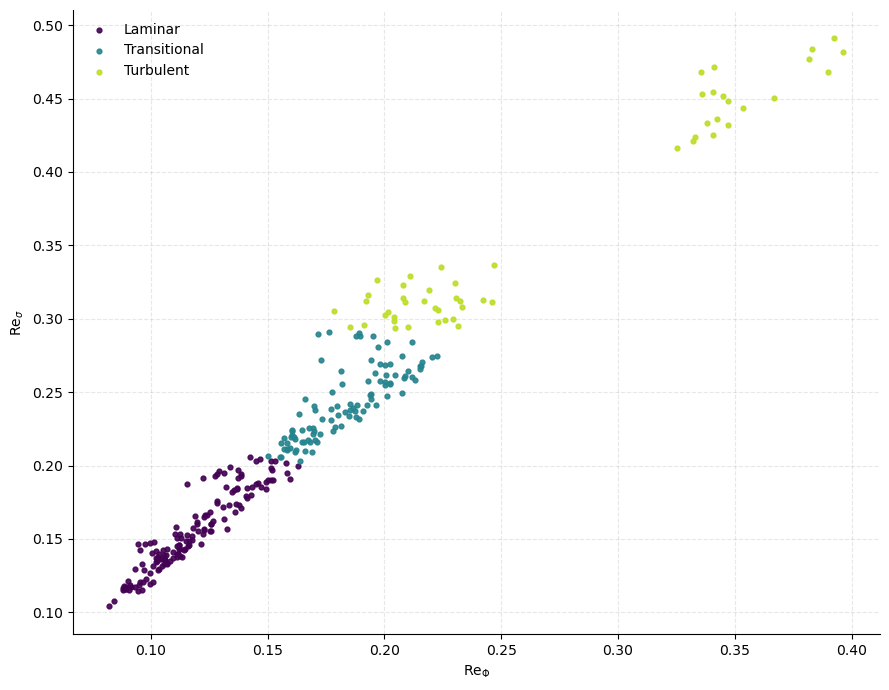

In [ ]:
# --- Regimes and colormap ---
regimes = ["Laminar", "Transitional", "Turbulent"]
cmap = plt.cm.viridis
palette = {r: cmap(t) for r, t in zip(regimes, np.linspace(0, 0.9, len(regimes)))}

# --- Prepare data ---
df = ml_df_HC_T.copy()                                                                      ##### CHANGE HERE #####
df["predicted_regime_svm"] = df["predicted_regime_svm"].str.capitalize()

xcol, ycol, hcol = "Re_phi", "Re_sigma", "predicted_regime_svm"

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 7))

# Background gray points
ax.scatter(df[xcol], df[ycol], s=8, color="#DADDE1", alpha=0.4, zorder=1)

# Colored points by regime
for reg in regimes:
    d = df[df[hcol] == reg]
    ax.scatter(d[xcol], d[ycol], s=12, alpha=0.9, color=palette[reg], zorder=2, label=reg)

# Labels
ax.set_xlabel(r"$\mathrm{Re}_{\Phi}$")
ax.set_ylabel(r"$\mathrm{Re}_{\sigma}$")

# Clean look (no top/right spines, subtle grid)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.3)

# Legend (if you want it removed, comment these two lines)
ax.legend(loc="upper left", frameon=False)

fig.tight_layout()
plt.show()

### Roll Quant

In [ ]:
best_svm, scaler_svm, res_svm = train_svm(training_list_RQ, test_size=0.25, class_weight='balanced')
print("Best SVM params:", res_svm['best_params'])
print("CV best (macro F1):", res_svm['cv_best_score_f1_macro'])
print(res_svm['classification_report'])

Best SVM params: {'C': 100, 'gamma': 1.0, 'kernel': 'rbf'}
CV best (macro F1): 0.33978333944598316
              precision    recall  f1-score   support

     laminar      0.165     0.523     0.251        86
transitional      0.835     0.405     0.545       687
   turbulent      0.197     0.581     0.294        86

    accuracy                          0.434       859
   macro avg      0.399     0.503     0.364       859
weighted avg      0.704     0.434     0.491       859



In [ ]:
# Concatenate your new testing DataFrames
ml_df_RQ_T = pd.concat(testing_list_RQ, ignore_index=True)

# Predict with trained SVM
X_new   = ml_df_RQ_T[['Re_phi','Re_sigma']].values
X_new_s = scaler_svm.transform(X_new)
svm_preds = best_svm.predict(X_new_s)
svm_probs = best_svm.predict_proba(X_new_s)   # optional: class probabilities

ml_df_RQ_T['predicted_regime_svm'] = svm_preds
print(ml_df_RQ_T['predicted_regime_svm'].value_counts())

predicted_regime_svm
transitional    121
turbulent       106
laminar          73
Name: count, dtype: int64


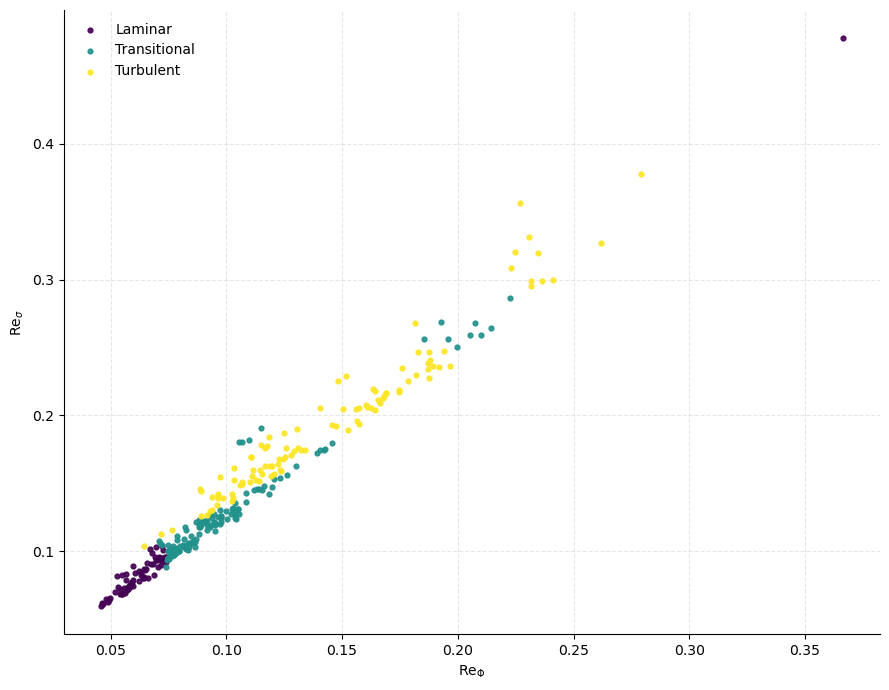

In [ ]:
# --- Regimes and colormap ---
regimes = ["Laminar", "Transitional", "Turbulent"]
cmap = plt.cm.viridis
palette = {r: cmap(t) for r, t in zip(regimes, np.linspace(0, 1, len(regimes)))}

# --- Prepare data ---
df = ml_df_RQ_T.copy()                                                                      ##### CHANGE HERE #####
df["predicted_regime_svm"] = df["predicted_regime_svm"].str.capitalize()

xcol, ycol, hcol = "Re_phi", "Re_sigma", "predicted_regime_svm"

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 7))

# Background gray points
ax.scatter(df[xcol], df[ycol], s=8, color="#DADDE1", alpha=0.4, zorder=1)

# Colored points by regime
for reg in regimes:
    d = df[df[hcol] == reg]
    ax.scatter(d[xcol], d[ycol], s=12, alpha=0.9, color=palette[reg], zorder=2, label=reg)

# Labels
ax.set_xlabel(r"$\mathrm{Re}_{\Phi}$")
ax.set_ylabel(r"$\mathrm{Re}_{\sigma}$")

# Clean look (no top/right spines, subtle grid)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.3)

# Legend (if you want it removed, comment these two lines)
ax.legend(loc="upper left", frameon=False)

fig.tight_layout()
plt.show()

### Hasb Quant

In [ ]:
best_svm, scaler_svm, res_svm = train_svm(training_list_HQ, test_size=0.25, class_weight='balanced')
print("Best SVM params:", res_svm['best_params'])
print("CV best (macro F1):", res_svm['cv_best_score_f1_macro'])
print(res_svm['classification_report'])

Best SVM params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
CV best (macro F1): 0.45733749296780274
              precision    recall  f1-score   support

     laminar      0.252     0.442     0.321        86
transitional      0.849     0.582     0.691       687
   turbulent      0.245     0.674     0.359        86

    accuracy                          0.577       859
   macro avg      0.449     0.566     0.457       859
weighted avg      0.729     0.577     0.621       859



In [ ]:
# Concatenate your new testing DataFrames
ml_df_HQ_T = pd.concat(testing_list_HQ, ignore_index=True)

# Predict with trained SVM
X_new   = ml_df_HQ_T[['Re_phi','Re_sigma']].values
X_new_s = scaler_svm.transform(X_new)
svm_preds = best_svm.predict(X_new_s)
svm_probs = best_svm.predict_proba(X_new_s)   # optional: class probabilities

ml_df_HQ_T['predicted_regime_svm'] = svm_preds
print(ml_df_HQ_T['predicted_regime_svm'].value_counts())

predicted_regime_svm
transitional    161
turbulent        98
laminar          41
Name: count, dtype: int64


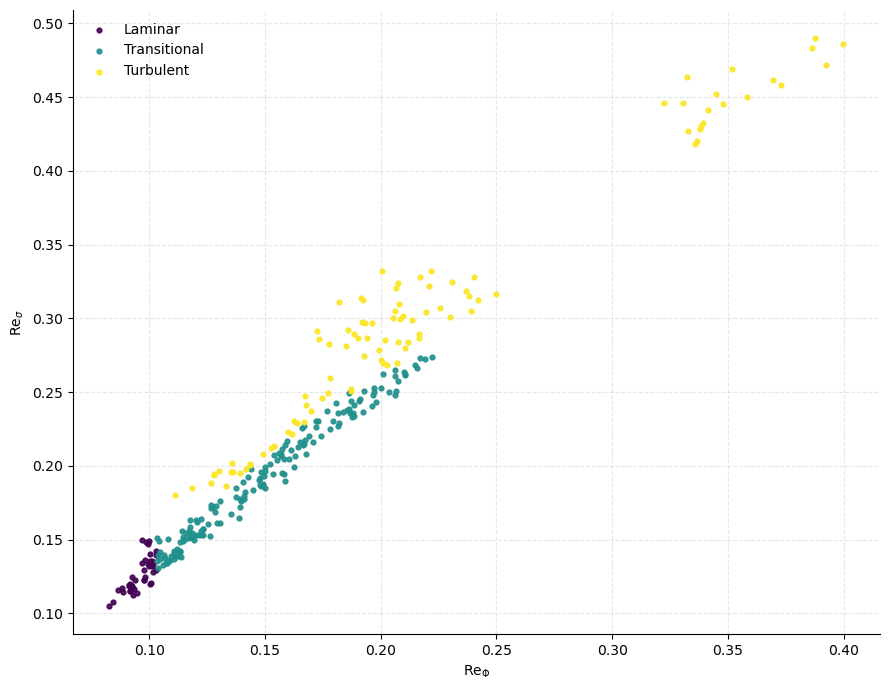

In [ ]:
# --- Regimes and colormap ---
regimes = ["Laminar", "Transitional", "Turbulent"]
cmap = plt.cm.viridis
palette = {r: cmap(t) for r, t in zip(regimes, np.linspace(0, 1, len(regimes)))}

# --- Prepare data ---
df = ml_df_HQ_T.copy()                                                                      ##### CHANGE HERE #####
df["predicted_regime_svm"] = df["predicted_regime_svm"].str.capitalize()

xcol, ycol, hcol = "Re_phi", "Re_sigma", "predicted_regime_svm"

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 7))

# Background gray points
ax.scatter(df[xcol], df[ycol], s=8, color="#DADDE1", alpha=0.4, zorder=1)

# Colored points by regime
for reg in regimes:
    d = df[df[hcol] == reg]
    ax.scatter(d[xcol], d[ycol], s=12, alpha=0.9, color=palette[reg], zorder=2, label=reg)

# Labels
ax.set_xlabel(r"$\mathrm{Re}_{\Phi}$")
ax.set_ylabel(r"$\mathrm{Re}_{\sigma}$")

# Clean look (no top/right spines, subtle grid)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.3)

# Legend (if you want it removed, comment these two lines)
ax.legend(loc="upper left", frameon=False)

fig.tight_layout()
plt.show()

## Extract Data

In [ ]:
# today   = "2025-07-18"
# one_W   = "2025-07-11"
# two_W   = "2025-07-04"
# one_M   = "2025-06-18"
# three_M = "2025-04-18"
# six_M   = "2025-01-18"
# one_Y   = "2024-07-18"
# two_Y   = "2023-07-18"
# five_Y  = "2020-07-18"
# ten_Y   = "2015-07-18"


# df_1W   = compute_financial_reynolds(assets, one_W, today, interval)
# df_2W   = compute_financial_reynolds(assets, two_W, today, interval)
# df_1M   = compute_financial_reynolds(assets, one_M, today, interval)
# df_3M   = compute_financial_reynolds(assets, three_M, today, interval)
# df_6M   = compute_financial_reynolds(assets, six_M, today, interval)
# df_1Y   = compute_financial_reynolds(assets, one_Y, today, interval)
# df_2Y   = compute_financial_reynolds(assets, two_Y, today, interval)
# df_5Y   = compute_financial_reynolds(assets, five_Y, today, interval)
# df_10Y  = compute_financial_reynolds(assets, ten_Y, today, interval)

In [ ]:
# df_1W  
# df_2W   
# df_1M   
# df_3M   
# df_6M   
# df_1Y  
# df_2Y   
# df_5Y   
# df_10Y  